In [84]:
import sys, re
from pathlib import Path
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import scipy.io.wavfile as wavfile
import datetime
from parselmouth import Sound
from parselmouth.praat import call as pcall
from scipy.signal import welch
import matplotlib.pyplot as plt
from IPython.display import Audio

from audiolabel import df2tg
from phonlab.utils import dir2df, get_timestamp_now
from phonlab.array import nonzero_groups

import ceti

## Locations and params

In [2]:
sheet_id = '1DeQQ-ZDuCumWMz21ouxfJpeSzyRAJykX'
sheet_name = 'Sheet1'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
url = f'https://docs.google.com/spreadsheets/d/1DeQQ-ZDuCumWMz21ouxfJpeSzyRAJykX/gviz/tq?tqx=out:csv&sheet={sheet_name}'

In [3]:
# Data locations
flacdir = Path('/global/scratch/users/rsprouse/datasets/ceti/CETIdata')
tgdir = flacdir.parent / 'tg'
specdir = flacdir.parent / 'spec'

# Analysis params
resample_rate = 120000
click_offset = -0.002
click_window = 0.015
click_window_str = '{}'.format(click_window).lstrip('0')
ltas_bw = 100 # Praat 'To Ltas...' bandwidth param
praat_spec_fast = False  # Praat 'To Spectrum...' fast param
dropIPI = True # If True, drop IPI# columns from google codas spreadsheet
conversation_sec = 20 # Max number of seconds between codas in a conversation

In [4]:
# Corrections to Jocasta spreadsheet data
jocastabadcodas = [str(n) for n in range(8627, 8671)]
jocastaoffset = 0.1537  # Time to subtract from TsTo for codas in `jocastabadcodas`

## Load `.flac` file info


In [5]:
flacdf = ceti.load_flac_info(flacdir)

## Read and merge with codas spreadsheet

In [6]:
# Merge classifiedCodas spreadsheet with available .flac files in flacdir.
# Only codas with matching .flac files are in the result.
gsheetdf = ceti.load_classified_codas(
    url,
    dropIPI=dropIPI,
    jocastacorrections={'codas':jocastabadcodas, 'offset': jocastaoffset},
    conversation_sec=conversation_sec
)
clicks = ceti.codadf2clickdf(gsheetdf, 'codaNUM2018', 'TsTo')
navalues = {
    k: '' for k in \
        ['codaNUM2018', 'Date', 'ELKI2name', 'IDN', 'Name', 'REC', 'Tag', 'TagOnTime', 'Unit']
}
clicks = flacdf.merge(
    clicks,
    how='inner',
    on='barename'
).fillna(navalues)
clicks['extract_t1'] = clicks['t1'] - clicks['foffset'] + click_offset
clicks['extract_t2'] = clicks['extract_t1'] + click_window
# Handle this after removing rows:
#clicks['audidx'] = np.arange(len(clicks), dtype=np.int32)  # Row (first dim) location of audio data in ndarray
clicks.head(50)

,relpath,fname,barename,ext,tag,fseq,flacrate,flacdur,foffset,codaNUM2018,...,codadt,convo,convoN,fileseq,nClicks,seg,ICI,t1,extract_t1,extract_t2
0,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133,8169,...,2014-04-16 13:36:54.404100,0,1,002,9,9999,0.038208,10000.404100,1725.049967,1725.064967
1,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133,8169,...,2014-04-16 13:36:54.404100,0,1,002,9,9999,0.042742,10000.442308,1725.088175,1725.103175
2,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133,8169,...,2014-04-16 13:36:54.404100,0,1,002,9,9999,0.044058,10000.485050,1725.130917,1725.145917
3,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133,8169,...,2014-04-16 13:36:54.404100,0,1,002,9,9999,0.041092,10000.529108,1725.174975,1725.189975
4,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133,8169,...,2014-04-16 13:36:54.404100,0,1,002,9,9999,0.048275,10000.570200,1725.216067,1725.231067
5,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133,8169,...,2014-04-16 13:36:54.404100,0,1,002,9,9999,0.049517,10000.618475,1725.264342,1725.279342
6,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133,8169,...,2014-04-16 13:36:54.404100,0,1,002,9,9999,0.057583,10000.667992,1725.313858,1725.328858
7,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133,8169,...,2014-04-16 13:36:54.404100,0,1,002,9,9999,0.065133,10000.725575,1725.371442,1725.386442
8,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133,8169,...,2014-04-16 13:36:54.404100,0,1,002,9,9999,0.000000,10000.790708,1725.436575,1725.451575
9,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133,8170,...,2014-04-16 13:36:59.577700,0,1,002,8,9999,0.035699,10005.577700,1730.223567,1730.238567


In [7]:
clicks.Date.unique()

array(['2014-04-16 00:00:00', '2014-04-24 00:00:00',
       '2014-04-29 00:00:00', '2015-02-03 00:00:00',
       '2015-03-02 00:00:00', '2015-03-19 00:00:00',
       '2015-03-26 00:00:00', '2015-03-31 00:00:00',
       '2015-01-04 00:00:00', '2015-07-04 00:00:00',
       '2015-10-04 00:00:00', '2016-12-04 00:00:00',
       '2016-04-24 00:00:00', '2016-12-05 00:00:00',
       '2016-05-12 00:00:00', '2016-05-13 00:00:00'], dtype=object)

In [8]:
badclick = clicks['extract_t2'] >= clicks['flacdur']
missingcodas = clicks[badclick]
#clicks = clicks[~badclick].reset_index(drop=True)
print(f"Removed {badclick.sum()} clicks from {(missingcodas['codaNUM2018'].unique().shape[0])} codas because of bad click times (TsTo > flac file duration).")
clicks

Removed 857 clicks from 158 codas because of bad click times (TsTo > flac file duration).


,relpath,fname,barename,ext,tag,fseq,flacrate,flacdur,foffset,codaNUM2018,...,codadt,convo,convoN,fileseq,nClicks,seg,ICI,t1,extract_t1,extract_t2
0,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133,8169,...,2014-04-16 13:36:54.404100,0,1,002,9,9999,0.038208,10000.404100,1725.049967,1725.064967
1,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133,8169,...,2014-04-16 13:36:54.404100,0,1,002,9,9999,0.042742,10000.442308,1725.088175,1725.103175
2,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133,8169,...,2014-04-16 13:36:54.404100,0,1,002,9,9999,0.044058,10000.485050,1725.130917,1725.145917
3,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133,8169,...,2014-04-16 13:36:54.404100,0,1,002,9,9999,0.041092,10000.529108,1725.174975,1725.189975
4,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133,8169,...,2014-04-16 13:36:54.404100,0,1,002,9,9999,0.048275,10000.570200,1725.216067,1725.231067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19510,2016,sw134a001.flac,sw134a001,.flac,sw134a,1,125000,7139.733280,0.000000,8878,...,2016-05-13 12:08:56.049200,149,1,001,5,458,0.097518,472.049200,472.047200,472.062200
19511,2016,sw134a001.flac,sw134a001,.flac,sw134a,1,125000,7139.733280,0.000000,8878,...,2016-05-13 12:08:56.049200,149,1,001,5,458,0.095510,472.146718,472.144718,472.159718
19512,2016,sw134a001.flac,sw134a001,.flac,sw134a,1,125000,7139.733280,0.000000,8878,...,2016-05-13 12:08:56.049200,149,1,001,5,458,0.070572,472.242228,472.240228,472.255228
19513,2016,sw134a001.flac,sw134a001,.flac,sw134a,1,125000,7139.733280,0.000000,8878,...,2016-05-13 12:08:56.049200,149,1,001,5,458,0.063327,472.312800,472.310800,472.325800


In [9]:
clicks.to_csv('clicks.csv', index=False)

In [10]:
suspect = (clicks['extract_t1'] <= 0) | (clicks['extract_t2'] >= clicks['flacdur'])
print(clicks[suspect]['TagOnTime'].unique())
print(clicks[suspect]['Tag'].unique())

['11:20:26' '07:57:09' '']
['sw061b' 'sw100b' 'sw133a']


In [11]:
clicks[suspect & (clicks['TagOnTime'] == '07:57:09')]['codaNUM2018'].unique()

array(['7915', '7916', '7917', '7918', '7919', '7920', '7921', '7922',
       '7923', '7924', '7925', '7926', '7927', '7928', '7929', '7930',
       '7931', '7932', '7933', '7934', '7935', '7936', '7937', '7939',
       '7940', '7941', '7942', '7943', '7944', '7945', '7946', '7947',
       '7948', '7949', '7950', '7951', '7952', '7953', '7954', '7955',
       '7956', '7957', '7958', '7959', '7960', '7961', '7962', '7963',
       '7964', '7965', '7966', '7967', '7968', '7969', '7970', '7971',
       '7972', '7973', '7974', '7975', '7976', '7977', '7978', '7979',
       '7980', '7981', '7982', '7983', '7984', '7985', '7986', '7987',
       '7988', '7989', '7990', '7991', '7992', '7993', '7994', '7995',
       '7996', '7997', '7998', '7999', '8000', '8001', '8002', '8003',
       '8004', '8005', '8006', '8007', '8008', '8009', '8010', '8011',
       '8012', '8013', '8014', '8015', '8016', '8017', '8018', '8019',
       '8020', '8021', '8022', '8023', '8024', '8025', '8026', '8027',
      

## Add behavioral metadata

In [12]:
bhvspreadsheet_id = '1WjwPJWWhS-7S2WiyA8buoWts8RNRN0-mHDzAIg4efxc'
bhvurl = f'https://docs.google.com/spreadsheets/d/{bhvspreadsheet_id}/export?format=csv'
bhvdf = pd.read_csv(bhvurl)
bhvdf['bhvdt'] = pd.to_datetime(
    bhvdf['date'].astype(str) + 'T' + bhvdf['time'],
    format='%Y%m%dT%H:%M'
)
#bhvdf['bhvdt.copy'] = bhvdf['bhvdt'].copy()
# Drop incomplete rows and sort by datetime
bhvdf = bhvdf.dropna(how='any', subset=['bhvdt', 'behavior'])
bhvdf = bhvdf.sort_values('bhvdt')
bhvdf

,date,time,behavior,maxNumClusters,meanNumIndivid,groupCompM,groupCompA,groupCompC,aerialBHV,comments,fromScan,bhvdt
0,20140416,10:00,FOR,2,1.5,0,3,0,-,"1A, 2A,",20140416 sw14_106ab GrpBhv.JPG,2014-04-16 10:00:00
1,20140416,11:00,FOR,4,1,0,4,0,-,"1A, 1A, 1A, 1A",20140416 sw14_106ab GrpBhv.JPG,2014-04-16 11:00:00
2,20140416,12:00,FOR,5,6/5,0,6,0,-,"1A, 2A, 1A, 1A, 1A",20140416 sw14_106ab GrpBhv.JPG,2014-04-16 12:00:00
3,20140416,13:00,FOR,6,9/6,0,7,1,-,"1A, 1AK, 2AK, 1A, 1A, 1A",20140416 sw14_106ab GrpBhv.JPG,2014-04-16 13:00:00
4,20140416,14:00,FOR,4,1.25,0,5,0,-,"1A, 2A, 1A, 1A",20140416 sw14_106ab GrpBhv.JPG,2014-04-16 14:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
72,20150331,15:00,FOR,3,7/3,0,5,1,-,"2A1C, 1A, 2A1C",20150331 sw15_090abc Grp Behav.JPG,2015-03-31 15:00:00
73,20150331,16:00,FOR,3,1.3 (RLS: 1 1/3),0,4,0,-,"1A, 1A, 2A",20150331 sw15_090abc Grp Behav.JPG,2015-03-31 16:00:00
74,20150331,17:00,FOR,6,1.3 (RLS: 1 1/3),0,7,1,-,"2A, 1A, 1A1C, 1A, 1A, 1A",20150331 sw15_090abc Grp Behav.JPG,2015-03-31 17:00:00
75,20150331,18:00,FOR,5,1.8,0,7,2,-,"2A, 1A, 1C, 1A1C, 3A, Blackfish",20150331 sw15_090abc Grp Behav.JPG,2015-03-31 18:00:00


In [13]:
# Drop incomplete rows and sort by datetime
nocodadt = clicks[clicks['codadt'].isna()].copy()
clicks = clicks.dropna(how='any', subset='codadt')
clicks = clicks.sort_values('codadt')
for direction, sfx in (('backward', 'bkwd'), ('forward', 'fwd'), ('nearest', 'near')):
    clicks = pd.merge_asof(
        clicks,
        bhvdf[['bhvdt', 'behavior']],
        left_on='codadt',
        right_on='bhvdt',
        suffixes=('', f'_{sfx}'),
        tolerance=pd.Timedelta('1 hour'),
        direction=direction
    ).rename({'bhvdt': f'bhvdt_{sfx}', 'behavior': f'bhv_{sfx}'}, axis='columns')

# Add back incomplete rows
clicks = pd.concat([clicks, nocodadt], axis='rows')

In [14]:
(clicks['bhvdt_near'] - clicks['codadt']).dt.components[['minutes', 'seconds']]

,minutes,seconds
0,23.0,5.0
1,23.0,5.0
2,23.0,5.0
3,23.0,5.0
4,23.0,5.0
...,...,...
18451,NaN,NaN
18452,NaN,NaN
18453,NaN,NaN
18454,NaN,NaN


In [15]:
# TODO: also check aws for new tag data and process
def summarize_behavior(g):
    return g.iloc[0]
myc = clicks[~clicks['bhvdt_bkwd'].isna()][['codaNUM2018', 'codadt', 'bhvdt_bkwd', 'bhv_bkwd', 'bhvdt_fwd', 'bhv_fwd', 'bhvdt_near', 'bhv_near']].groupby('codaNUM2018').apply(summarize_behavior, include_groups=False)
myc.to_csv('allcodas-behavior.csv', index=True)
myc

,codadt,bhvdt_bkwd,bhv_bkwd,bhvdt_fwd,bhv_fwd,bhvdt_near,bhv_near
codaNUM2018,,,,,,,
5256,2015-03-02 15:20:25.296100000,2015-03-02 15:00:00,FOR,2015-03-02 16:00:00,SOC/FOR,2015-03-02 15:00:00,FOR
5257,2015-03-02 15:20:29.133399999,2015-03-02 15:00:00,FOR,2015-03-02 16:00:00,SOC/FOR,2015-03-02 15:00:00,FOR
5258,2015-03-02 15:20:32.862900000,2015-03-02 15:00:00,FOR,2015-03-02 16:00:00,SOC/FOR,2015-03-02 15:00:00,FOR
5259,2015-03-02 15:20:43.865200000,2015-03-02 15:00:00,FOR,2015-03-02 16:00:00,SOC/FOR,2015-03-02 15:00:00,FOR
5260,2015-03-02 15:20:48.244600000,2015-03-02 15:00:00,FOR,2015-03-02 16:00:00,SOC/FOR,2015-03-02 15:00:00,FOR
...,...,...,...,...,...,...,...
8622,2014-04-29 11:23:59.494500000,2014-04-29 11:00:00,RST,2014-04-29 12:00:00,RST/FOR,2014-04-29 11:00:00,RST
8623,2014-04-29 11:24:03.334600000,2014-04-29 11:00:00,RST,2014-04-29 12:00:00,RST/FOR,2014-04-29 11:00:00,RST
8624,2014-04-29 11:24:07.453700000,2014-04-29 11:00:00,RST,2014-04-29 12:00:00,RST/FOR,2014-04-29 11:00:00,RST


## Extract click audio

Make a 3d ndarray of click audio. Dimensions: `click (coda + clicknum), channel (left|right), samples`.

Normalize by removing DC offset and scaling peak magnitude to 1.0.

In [11]:
# Sort by audio file and coda for fewer IO open operations. Add a zero-based column that can
# be used to match rows (first dimension) of extracted audio ndarray.
clicks = clicks.sort_values(['Tag', 'codaNUM2018']).reset_index(drop=True).reset_index(names='audidx')
#clicks

In [ ]:
clickaudio = ceti.extract_click_audio(
    clicks, 'codaNUM2018', 't1', click_offset, click_window, flacdir, resample_rate, 'Tag'
)
clickaudio = ceti.normalize_audio(clickaudio, remdc=True, peak_scale=None)

In [ ]:
assert(~np.isnan(clickaudio).any())
clickaudio.shape

In [ ]:
print(clicks[clicks['audidx'] == 420])

In [ ]:
print(clicks[(clicks['codaNUM2018'] == '5031') & (clicks['clicknum'] == 1)])
plt.plot(clickaudio[420, 0, :300]);

In [ ]:
clicks[(clicks['codaNUM2018'] == '5031')]

### Make sure clickaudio matches clicks dataframe

In [ ]:
# Randomly test a number of audio clicks to make sure they appear in the proper order
# in `clickaudio`.
ntest = 1000
for row in clicks.sample(ntest).itertuples():
    aufile = Path(flacdir) / row.relpath / f"{row.Tag}.flac"
    randaud = ceti.get_single_click_audio(aufile, row.t1, click_offset, click_window, resample_rate, verbose=False)
    randaud = ceti.normalize_audio(randaud, remdc=True, peak_scale=None)
    assert((clickaudio[row.Index] == randaud).all())
print('SUCCESS')
row

In [ ]:
idx = 420
chan = 0
rng = np.arange(0, 500)
row = clicks.iloc[idx]
aufile = Path(flacdir) / row['relpath'] / f"{row['Tag']}.flac"
print(aufile)
randaud = ceti.get_single_click_audio(aufile, row['t1'], click_offset, click_window, resample_rate)
print(f'Got {randaud.shape} from {aufile}')
mu = randaud.mean(axis=-1, keepdims=True)
randaud -= mu # Remove DC offset
#randaud /= np.abs(randaud).max(axis=-1, keepdims=True) * 1.0  # Normalize max magnitude to 0.99
try:
    assert((clickaudio[idx, chan, :] == randaud[chan, :]).all())
    print('SUCCESS: samples match')
except AssertionError:
    print('ERROR: samples do not match')
fig, axs = plt.subplots(2, figsize=[10, 8])
axs[0].plot(clickaudio[idx, chan, rng])
axs[1].plot(randaud[chan, rng]);

## Concatenate and save all audio and corresponding to dataframe

In [ ]:
tstamp = get_timestamp_now()[0]
print(tstamp)

In [ ]:
# Save all extracted audio as 'unscaled' and 'pknorm'.
for s, saudio in (('unscaled', clickaudio), ('pknorm', ceti.normalize_audio(clickaudio.copy(), remdc=False, peak_scale=1.0))):
    for chanidx, chanstr in enumerate(('left', 'right')):
        outfile = flacdir.parent / f'allclicks.{chanstr}.{tstamp}.{s}.{saudio.shape[-1]}samples.wav'
        wavfile.write(outfile, resample_rate, saudio[:,chanidx,:].ravel())
#        sf.write(outfile, clickaudio[:,chanidx,:].ravel(), resample_rate) # This seems to scale audio
        print(outfile)

# Save click dataframe. The `audidx` column matches dataframe rows to
# its sequence in the audio file.
csvout = flacdir.parent / f'allclicks.{tstamp}.csv'
clicks.to_csv(csvout, index=False)
print(csvout)

In [ ]:
tstamp, outfile

### Concatenate and save a subset of extracted audio

In [ ]:
# Get desired subset of clicks and matching audio
mydf = clicks[clicks['Focal'] == 1].copy()
selaudio = clickaudio[mydf.index]
selaudio2 = clickaudio[clicks[clicks['Focal'] == 1]['audidx']]
selaudio3 = clickaudio[mydf.sort_values('TagOnTime').reset_index(drop=True).index]
selaudio4 = clickaudio[clicks.sort_values('TagOnTime').reset_index(drop=True)[clicks['Focal'] == 1]['audidx']]
assert(mydf.shape[0] == selaudio.shape[0])

In [ ]:
clicks[clicks['Focal'] == 1]

In [ ]:
clicks[clicks['Focal'] == 1][['audidx', 'Focal', 'tag', 'TsTo', 'TagOnTime']].sort_values('TagOnTime').reset_index(drop=True)

In [ ]:
clicks[clicks['Focal'] == 1].sort_values('TagOnTime').reset_index(drop=True)[['audidx', 'Focal', 'tag', 'TsTo', 'TagOnTime']]

In [ ]:
(selaudio == selaudio4).all()

In [ ]:
selaudio.shape == selaudio4.shape

In [ ]:
plt.plot(selaudio[47, 0, :300]);

In [ ]:
plt.plot(selaudio4[47, 0, :300]);

In [ ]:
mydf.index

In [ ]:
# Now reset index to zero-based to match selaudio
mydf = mydf.reset_index(drop=True)

In [ ]:
mydf.index

In [ ]:
mydf[(mydf['codaNUM2018'] == '5031')]

In [ ]:
plt.plot(clickaudio[420, 0, :300]);

In [ ]:
plt.plot(selaudio[275, 0, :300]);

In [ ]:
# And sort as desired. The index will be used to select first dim of selaudio.
mydf = mydf.sort_values(['Name', 'codaNUM2018', 'clicknum'])

In [ ]:
mydf.index

In [ ]:
mydf[(mydf['codaNUM2018'] == '5031')]

In [ ]:
plt.plot(selaudio[1422, 1, :350]);

In [ ]:
mydf.index

In [ ]:
# Optionally save the audio
saveaudio = selaudio[mydf.index]
tstamp = get_timestamp_now()[0]
leftout = specdir.parent / f'clicks.focal.left.{tstamp}.wav'
rightout = specdir.parent / f'clicks.focal.right.{tstamp}.wav'
sf.write(leftout, saveaudio[:,0,:].ravel(), resample_rate)
sf.write(rightout, saveaudio[:,1,:].ravel(), resample_rate)

In [ ]:
plt.plot(saveaudio[275,0,:350])

### Create and save associated textgrid

In [ ]:
mydf = mydf.reset_index(drop=True)
mydf #.index

In [ ]:
codadf[codadf['text'] == '5031']

In [ ]:
mydf = codadf.reset_index(drop=True)

In [ ]:
whaledf = pd.DataFrame({
    'text': mydf[~mydf['Name'].duplicated()]['Name'],
    't1': mydf[~mydf['Name'].duplicated()].index * click_window,
    't2': mydf[~mydf['Name'].duplicated(keep='last')].index * click_window + click_window
})
whaledf

codadf = pd.DataFrame({
    'text': mydf[~mydf['codaNUM2018'].duplicated()]['codaNUM2018'],
    't1': mydf[~mydf['codaNUM2018'].duplicated()].index * click_window,
    't2': mydf[~mydf['codaNUM2018'].duplicated(keep='last')].index * click_window + click_window
})
codadf

clickdf = pd.DataFrame({
    'text': mydf['clicknum'].astype(str),
    't1': mydf.index * click_window,
    't2': mydf.index * click_window + click_window
})
clickdf

clicktg = df2tg(
    [whaledf, codadf, clickdf],
    tnames=['whale', 'coda', 'clicknum'],
    lbl='text',
    fmt='0.4f',
    fill_gaps=None,
    outfile=specdir.parent / f'clicks.focal.{tstamp}.TextGrid'
)

## Spectral analysis with `scipy.welch`

In [ ]:
welchfreqs, wspec = welch(clickaudio, fs=resample_rate, nperseg=clickaudio.shape[-1]) #, window='boxcar')
welchfreqcols = [f'Hz{f}' for f in np.round(welchfreqs).astype(int)]

In [ ]:
idx = 1147
fig, axs = plt.subplots(3, 2, figsize=[10, 8]);
axs[0, 0].plot(clickaudio[idx,0,:]);
axs[0, 1].plot(clickaudio[idx,1,:]);
axs[1, 0].plot(welchfreqs, wspec[idx,0]);
axs[1, 1].plot(welchfreqs, wspec[idx,1]);
axs[2, 0].plot(welchfreqs, 10*np.log10(wspec[idx,0]/2e-5));
axs[2, 1].plot(welchfreqs, 10*np.log10(wspec[idx,1]/2e-5));
audbit = Audio(data=clickaudio[idx], rate=resample_rate)
display(audbit)

### Combine metadata with spectral analysis and save

In [ ]:
subdf = clicks.head(6)
subdf

In [ ]:
wspecleftdf = pd.DataFrame(wspec[:, 0], columns=welchfreqcols)
wspecleftdf.head(6).T.plot();

In [ ]:
# Check that allcodas matches wspec (same length and increments from zero)
assert(clicks.shape[0] == wspec.shape[0])
assert(clicks.index.start == 0)
assert(clicks.index.stop == wspec.shape[0])
clicksfreqswide = pd.merge(
    clicks,
    pd.DataFrame(wspec[:, 0], columns=welchfreqcols),
    how='inner',
    left_index=True,
    right_index=True
)
# There must be a matching frequency analysis for every coda-click in allcodas
assert(clicks.shape[0] == clicksfreqswide.shape[0])

In [ ]:
clicksfreqslong = pd.wide_to_long(
    clicksfreqswide,
    stubnames='Hz',
    i=('codaNUM2018', 'clicknum'),
    j='binHz'
) \
.rename({'Hz': 'wspec'}, axis='columns') \
.reset_index()

In [ ]:
# Verify that shape of result is as expected (bin frequency columns converted to rows for each coda-click)
# (The +2 accounts for the ('codaNUM2018', 'clicknum') columns.)
assert(
    (clicksfreqswide.shape[1] - clicksfreqslong.shape[1] + 2) * clicksfreqswide.shape[0] == clicksfreqslong.shape[0]
)
clicksfreqswide.shape, clicksfreqslong.shape

In [ ]:
tstampfreq = get_timestamp_now()[0]
clicksfreqswide.to_csv(specdir / f'clicks.welch.wide.{tstampfreq}.csv', index=False)

In [ ]:
clicksfreqslong.to_csv(specdir / f'clicks.welch.long.{tstampfreq}.csv', index=False)

### Read from `.csv` file

In [ ]:
widecachedf = pd.read_csv(specdir / f'clicks.welch.wide.{tstampfreq}.csv')
widecachedf.head()

In [ ]:
specdir / f'clicks.welch.wide.{tstampfreq}.csv'

In [ ]:
longcachedf = pd.read_csv(specdir / 'clicks.welch.long.20231010.csv')
longcachedf.head()

## Extract coda audio

In [60]:
def extract_coda_audio(clickdf, codacol, t1col, click_offset, click_window,
    audiodir, resample_rate, groupby, pad):
    '''
    Extract audio chunks for each coda in a dataframe.
    
    For better IO performance reads are grouped by audio file, indicated by
    the `groupby` param.
    '''
    audio = {}
    for _, audf in clickdf.groupby(groupby):
        aufile = Path(audiodir) / \
                 audf.iloc[0]['relpath'] / \
                 f"{audf.iloc[0][groupby]}{audf.iloc[0]['ext']}"
        with sf.SoundFile(aufile, 'r') as fh:
            sr_native = fh.samplerate
            if sr_native < resample_rate:
                sys.stderr.write(
                    f'WARNING: Upsampling {aufile} from {sr_native} to {resample_rate}.\n'
                )
            for __, cdf in audf.groupby(codacol):
                t1 = cdf['t1'].min() + click_offset - pad
                t2 = cdf['t1'].max() + click_offset + click_window + pad
                nsamp = np.round((t2 - t1) * sr_native).astype(int)
                try:
                    fh.seek(np.round((t1 + click_offset) * sr_native).astype(int))
                    # Load the target number of frames, and transpose to match librosa form
                    y = fh.read(frames=nsamp, dtype=np.float32, always_2d=False).T
                    if sr_native != resample_rate:
                        y = librosa.resample(
                            y, orig_sr=sr_native, target_sr=resample_rate
                        )
                    audio[cdf['codaNUM2018'].iloc[0]] = {'audio': y, 'clicks': cdf, 't1': t1, 'nsamp': nsamp, 'pad': pad}
                except Exception as e:
                    sys.stderr.write(e)
                    break
    return audio

In [61]:
pad = 0.200
codaaudio = extract_coda_audio(
    clicks, 'codaNUM2018', 't1', click_offset, click_window, flacdir, resample_rate, 'Tag', pad
)
#clickaudio = ceti.normalize_audio(clickaudio, remdc=True, peak_scale=None)

In [66]:
import pickle
codaoutfile = specdir.parent / 'codaaudio.pyc'
with open(codaoutfile, 'wb') as codafh:
    pickle.dump(codaaudio, codafh)
print(codaoutfile)

/global/scratch/users/rsprouse/datasets/ceti/codaaudio.pyc


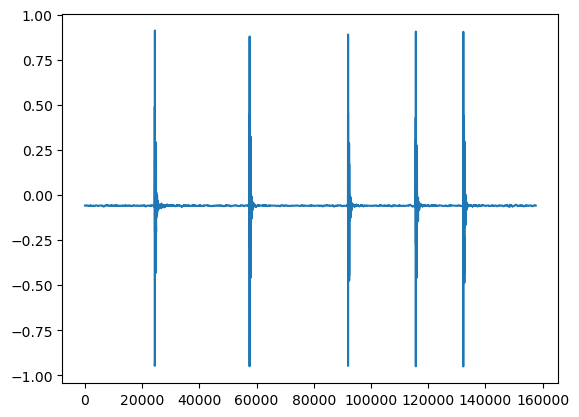

In [62]:
plt.plot(codaaudio['4933']['audio'][0,:]);

## Conversations

In [16]:
convocols = ['Tag', 'codaNUM2018', 'clicknum', 'Date', 'TagOnTime', 'TsTo', 'codadt', 'Name', 'convo', 'convoN']

In [17]:
monologdf = clicks[clicks['convoN'] == 1].copy()
multilogdf = clicks[clicks['convoN'] > 1].copy()
monologdf['convo'].unique(), multilogdf['convo'].unique()

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  22,  23,  26,  28,  29,  30,  31,  32,  33,  34,  35,
         36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
         49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
         62,  63,  64,  65,  66,  68,  69,  70,  71,  72,  73,  74,  75,
         76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
         89,  90,  91,  92,  93,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158]),
 array([15, 16, 17, 18, 19, 20, 21, 24, 25, 27, 67, 94]))

In [18]:
multilogdf['Date'].unique()

array(['2014-04-29 00:00:00', '2015-01-04 00:00:00',
       '2015-03-19 00:00:00', '2015-03-31 00:00:00'], dtype=object)

In [19]:
multilogdf[multilogdf['convo'] == 27][convocols].sort_values(['codadt', 'clicknum']).head(50)

,Tag,codaNUM2018,clicknum,Date,TagOnTime,TsTo,codadt,Name,convo,convoN
2498,sw091a,7601,1,2015-01-04 00:00:00,08:36:36,15063.7970,2015-01-04 12:47:39.797000,TBB,27,2
2503,sw091a,7601,2,2015-01-04 00:00:00,08:36:36,15063.7970,2015-01-04 12:47:39.797000,TBB,27,2
2499,sw091a,7601,3,2015-01-04 00:00:00,08:36:36,15063.7970,2015-01-04 12:47:39.797000,TBB,27,2
2500,sw091a,7601,4,2015-01-04 00:00:00,08:36:36,15063.7970,2015-01-04 12:47:39.797000,TBB,27,2
2501,sw091a,7601,5,2015-01-04 00:00:00,08:36:36,15063.7970,2015-01-04 12:47:39.797000,TBB,27,2
2497,sw091a,7601,6,2015-01-04 00:00:00,08:36:36,15063.7970,2015-01-04 12:47:39.797000,TBB,27,2
2502,sw091a,7601,7,2015-01-04 00:00:00,08:36:36,15063.7970,2015-01-04 12:47:39.797000,TBB,27,2
2504,sw091a,7602,1,2015-01-04 00:00:00,08:36:36,15068.0553,2015-01-04 12:47:44.055300,TBB,27,2
2505,sw091a,7602,2,2015-01-04 00:00:00,08:36:36,15068.0553,2015-01-04 12:47:44.055300,TBB,27,2
2510,sw091a,7602,3,2015-01-04 00:00:00,08:36:36,15068.0553,2015-01-04 12:47:44.055300,TBB,27,2


In [187]:
def extract_convo_audio_old(convodf, audiodir, resample_rate, convopad):
    '''
    Extract audio tracks for a conversation.
    
    '''
    audio = []
    sampcnts = set()
    for g in convodf.groupby('convo'):
        g[1]['Date'] = pd.to_datetime(g[1]['Date'], format='%Y-%m-%d 00:00:00')
        g[1]['TagOnTime'] = pd.to_timedelta(g[1]['TagOnTime'])
        g[1]['flac_t1'] = g[1]['Date'] + g[1]['TagOnTime']  # Start datetime of .flac file.
        g[1]['convot1'] = (g[1]['codadt'].min() - convopad - g[1]['flac_t1']).dt.total_seconds()
        g[1]['convot2'] = (g[1]['codadt'].max() + convopad - g[1]['flac_t1']).dt.total_seconds()
        for tg in g[1].groupby('tag'):
            convot1 = tg[1]['convot1'].iloc[0]
            convot2 = tg[1]['convot2'].iloc[0]
            aufile = Path(audiodir) / \
                tg[1]['relpath'].iloc[0] / \
                tg[1]['fname'].iloc[0]
            with sf.SoundFile(aufile, 'r') as fh:
                sr_native = fh.samplerate
                if sr_native < resample_rate:
                    sys.stderr.write(
                        f'WARNING: Upsampling {aufile} from {sr_native} to {resample_rate} Hz.\n'
                    )
                nsamp = int((convot2 - convot1) * sr_native)
                sampcnts.add(nsamp)
                try:
                    fh.seek(int(convot1 * sr_native))
                    # Load the target number of frames, and transpose to match librosa form
                    y = fh.read(frames=nsamp, dtype=np.float32, always_2d=False).T
                    if sr_native != resample_rate:
                        y = librosa.resample(
                            y, orig_sr=sr_native, target_sr=resample_rate
                        )
                    audio.append(y)
                except Exception as e:
                    sys.stderr.write(f'Could not read {aufile} from {convot1} to {convot2}: {e}')
    # Make sure arrays are the same length, just in case durations are slightly different.
    sampcnts = np.array(list(sampcnts))
    padto = sampcnts.max()
    for i, a in enumerate(audio):
        if a.shape[-1] < padto:
            if len(a.shape) == 2:
                audio[i] = np.pad(a, pad_width=((0, 0), (0, padto - a.shape[-1])))
            elif len(a.shape) == 1:
                audio[i] = np.pad(a, pad_width=(0, padto - a.shape[-1]))
            else:
                sys.stderr.write(f'Padding of audio with more than two channels not implemented.\n')
    try:
        audio = np.array(audio)
        audio = np.reshape(audio, (-1, audio.shape[-1]))
    except:
        pass
    return audio, sampcnts

def combine_overlaps(df):
    '''
    Find dataframe rows that overlap in time and combine them, dropping
    original rows
    '''
    df = pd.concat(
        [
            df,
            pd.DataFrame({
                'overlaps_following': (df['t1'].shift(-1) < df['t2']).iloc[:-1]
            }, index=df['t2'].index)
        ], axis='columns')
    df['is_overlapped'] = df['overlaps_following'].shift(1)
    overlapidx = df[df['overlaps_following'] | df['is_overlapped']].index
    dfs = [df]
    for i0, i1 in (zip(overlapidx[::2], overlapidx[1::2])):
        dfs.append(
            pd.DataFrame({
                'codaNUM2018': [df.loc[i0, 'codaNUM2018']][0] + '/' + \
                               [df.loc[i1, 'codaNUM2018']][0],
                't1': min([df.loc[i0, 't1'], df.loc[i1, 't1']]),
                't2': max([df.loc[i0, 't2'], df.loc[i1, 't2']]),
                'text': [df.loc[i1, 'text']][0]                        
            }, index=[-1])
        )
    df = pd.concat(dfs, axis='rows')
    df = df.drop(overlapidx).sort_values('t1')
    return df

def extract_convo_audio(convodf, audiodir, resample_rate, convopad):
    '''
    Extract audio tracks for a conversation.
    
    '''
    audio = []
    sampcnts = set()
    convodf['Date'] = pd.to_datetime(g[1]['Date'], format='%Y-%m-%d 00:00:00')
    convodf['TagOnTime'] = pd.to_timedelta(g[1]['TagOnTime'])
    convodf['flac_t1'] = convodf['Date'] + g[1]['TagOnTime']  # Start datetime of .flac file.
    convodf['convot1'] = (
        convodf['codadt'].min() - convopad - convodf['flac_t1']
    ).dt.total_seconds()
    convodf['convot2'] = (
        convodf['codadt'].max() + convopad - convodf['flac_t1']
    ).dt.total_seconds()
    tiers = {}
    for tg in convodf.groupby('tag'):
        tgdf = tg[1].sort_values('extract_t1').copy()
        convot1 = tgdf['convot1'].iloc[0]
        convot2 = tgdf['convot2'].iloc[0]
        aufile = Path(audiodir) / \
            tgdf['relpath'].iloc[0] / \
            tgdf['fname'].iloc[0]
        with sf.SoundFile(aufile, 'r') as fh:
            sr_native = fh.samplerate
            if sr_native < resample_rate:
                sys.stderr.write(
                    f'WARNING: Upsampling {aufile} from {sr_native} to {resample_rate} Hz.\n'
                )
            nsamp = int((convot2 - convot1) * sr_native)
            sampcnts.add(nsamp)
            try:
                fh.seek(int(convot1 * sr_native))
                # Load the target number of frames, and transpose to match librosa form
                y = fh.read(frames=nsamp, dtype=np.float32, always_2d=False).T
                if sr_native != resample_rate:
                    y = librosa.resample(
                        y, orig_sr=sr_native, target_sr=resample_rate
                    )
                audio.append(y)
            except Exception as e:
                sys.stderr.write(f'Could not read {aufile} from {convot1} to {convot2}: {e}')
        # Make textgrid tier for tag
        tagcodadf = \
            tgdf[['codaNUM2018', 'extract_t1']].groupby('codaNUM2018').apply(np.minimum.reduce, include_groups=False).join(
            [
                tgdf[['codaNUM2018', 'extract_t2']].groupby('codaNUM2018').apply(np.maximum.reduce, include_groups=False),
                tgdf[['codaNUM2018', 'bhv_bkwd', 'bhv_fwd', 'bhv_near']].fillna('').groupby('codaNUM2018').apply(lambda x: x.agg(";".join, axis='columns').iloc[0], include_groups=False)
            ]
        ).reset_index().rename({'extract_t1': 't1', 'extract_t2': 't2', 0: 'text'}, axis='columns')
        tagcodadf[['t1', 't2']] -= convot1
        tagcodadf = combine_overlaps(tagcodadf.sort_values('t1'))
        tagcodadf['text'] = tagcodadf['codaNUM2018'] + '\n' + tagcodadf['text']
        tiers[tgdf['Name'].iloc[0]] = tagcodadf
    # Make sure arrays are the same length, just in case durations are slightly different.
    sampcnts = np.array(list(sampcnts))
    padto = sampcnts.max()
    for i, a in enumerate(audio):
        if a.shape[-1] < padto:
            if len(a.shape) == 2:
                audio[i] = np.pad(a, pad_width=((0, 0), (0, padto - a.shape[-1])))
            elif len(a.shape) == 1:
                audio[i] = np.pad(a, pad_width=(0, padto - a.shape[-1]))
            else:
                sys.stderr.write(f'Padding of audio with more than two channels not implemented.\n')
    try:
        audio = np.array(audio)
        audio = np.reshape(audio, (-1, audio.shape[-1]))
    except:
        pass
    return audio, sampcnts, convodf, tiers

In [180]:
# Debugging cell
convodf
tiers = {}
for tg in convodf.groupby('tag'):
        tgdf = tg[1].sort_values('extract_t1').copy()
        convot1 = tgdf['convot1'].iloc[0]
        convot2 = tgdf['convot2'].iloc[0]
        tagcodadf = \
            tgdf[['codaNUM2018', 'extract_t1']].groupby('codaNUM2018').apply(np.minimum.reduce, include_groups=False).join(
            [
                tgdf[['codaNUM2018', 'extract_t2']].groupby('codaNUM2018').apply(np.maximum.reduce, include_groups=False),
                tgdf[['codaNUM2018', 'bhv_bkwd', 'bhv_fwd', 'bhv_near']].fillna('').groupby('codaNUM2018').apply(lambda x: x.agg(";".join, axis='columns').iloc[0], include_groups=False)
            ]
        ).reset_index().rename({'extract_t1': 't1', 'extract_t2': 't2', 0: 'text'}, axis='columns')
        tagcodadf[['t1', 't2']] -= convot1
        tagcodadf = combine_overlaps(tagcodadf.sort_values('t1'))
        tagcodadf['text'] = tagcodadf['codaNUM2018'] + '\n' + tagcodadf['text']
        tiers[tgdf['Name'].iloc[0]] = tagcodadf
tagcodadf

,codaNUM2018,t1,t2,text,overlaps_following,is_overlapped
13,7242,142.6154,143.367900,7242\nFOR/SOC;FOR/SOC;FOR/SOC,False,None
-1,7243/7227,146.9204,148.086180,7243/7227\n7243/7227\nFOR/SOC;FOR/SOC;FOR/SOC,NaN,NaN
1,7228,151.0841,152.069108,7228\nFOR/SOC;FOR/SOC;FOR/SOC,False,False
-1,7244/7229,154.5333,155.733125,7244/7229\n7244/7229\nFOR/SOC;FOR/SOC;FOR/SOC,NaN,NaN
-1,7230/7245,158.2093,159.428675,7230/7245\n7230/7245\nFOR/SOC;FOR/SOC;FOR/SOC,NaN,NaN
4,7231,162.4625,163.422842,7231\nFOR/SOC;FOR/SOC;FOR/SOC,False,False
5,7232,166.3144,167.315358,7232\nFOR/SOC;FOR/SOC;FOR/SOC,False,False
6,7233,170.7077,171.683108,7233\nFOR/SOC;FOR/SOC;FOR/SOC,False,False
7,7234,176.0920,177.090475,7234\nFOR/SOC;FOR/SOC;FOR/SOC,False,False
8,7235,180.5127,181.470008,7235\nFOR/SOC;FOR/SOC;FOR/SOC,False,False


In [189]:
!rm /global/scratch/users/rsprouse/datasets/ceti/convo/*.wav
!rm /global/scratch/users/rsprouse/datasets/ceti/convo/*.TextGrid

tstamp = get_timestamp_now()[0]
for g in multilogdf.groupby('convo'):
    convopad = pd.to_timedelta(60, unit='seconds')
    g[1].loc[:, ['bhv_bkwd', 'bhv_fwd', 'bhv_near']].fillna('', inplace=True)
    audio, sampcnts, convodf, tiers = extract_convo_audio(g[1], flacdir, resample_rate, convopad)
    outfile = specdir.parent / 'convo' / f"convo.{g[1]['barename'].iloc[0]}.{g[1]['convo'].iloc[0]}.{g[1]['TsTo'].iloc[0]}.{tstamp}.wav"
    sf.write(outfile, audio.T, resample_rate)
    print(f'Wrote {outfile}')
    try:
        clicktg = df2tg(
            list(tiers.values()),
            tnames=list(tiers.keys()),
            lbl='text',
            fmt='0.4f',
            start=0.0,
            end=audio.shape[1] / resample_rate,
            outfile=outfile.with_suffix('.TextGrid')
        )
        print(f"Wrote {outfile.with_suffix('.TextGrid')}")
    except Exception as e:
        sys.stderr.write(f'{e}\n')

Wrote /global/scratch/users/rsprouse/datasets/ceti/convo/convo.sw119b001.15.105.7594.2024-03-18T102315.wav
Wrote /global/scratch/users/rsprouse/datasets/ceti/convo/convo.sw119b001.15.105.7594.2024-03-18T102315.TextGrid
Wrote /global/scratch/users/rsprouse/datasets/ceti/convo/convo.sw119b001.16.176.7316.2024-03-18T102315.wav
Wrote /global/scratch/users/rsprouse/datasets/ceti/convo/convo.sw119b001.16.176.7316.2024-03-18T102315.TextGrid
Wrote /global/scratch/users/rsprouse/datasets/ceti/convo/convo.sw119b001.17.1020.9177.2024-03-18T102315.wav
Wrote /global/scratch/users/rsprouse/datasets/ceti/convo/convo.sw119b001.17.1020.9177.2024-03-18T102315.TextGrid
Wrote /global/scratch/users/rsprouse/datasets/ceti/convo/convo.sw119b001.18.1185.8.2024-03-18T102315.wav
Wrote /global/scratch/users/rsprouse/datasets/ceti/convo/convo.sw119b001.18.1185.8.2024-03-18T102315.TextGrid
Wrote /global/scratch/users/rsprouse/datasets/ceti/convo/convo.sw119a001.19.3560.176.2024-03-18T102315.wav
Wrote /global/scrat

Could not read /global/scratch/users/rsprouse/datasets/ceti/CETIdata/2015/sw091a003.flac from 15003.797 to 15268.0105: Internal psf_fseek() failed.Could not read /global/scratch/users/rsprouse/datasets/ceti/CETIdata/2015/sw091b002.flac from 12993.797 to 13258.0105: Internal psf_fseek() failed.tuple index out of range


Wrote /global/scratch/users/rsprouse/datasets/ceti/convo/convo.sw078c001.67.697.165.2024-03-18T102315.wav


Dataframe labels not sorted by time or duplicate times found.


Wrote /global/scratch/users/rsprouse/datasets/ceti/convo/convo.sw090a001.94.1053.477.2024-03-18T102315.wav
Wrote /global/scratch/users/rsprouse/datasets/ceti/convo/convo.sw090a001.94.1053.477.2024-03-18T102315.TextGrid


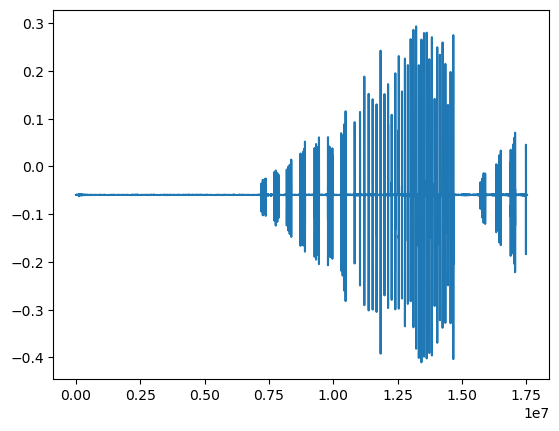

In [208]:
plt.plot(audio[3]);

In [193]:
#b = np.pad(a, pad_width=(0, (0, padto - a.shape[-1])))
b = np.pad(a, pad_width=((0, 0), (0, padto - a.shape[-1])))
b.shape

(2, 17521282)

In [123]:
convopad = pd.to_timedelta(60, unit='seconds')
for g in multilogdf.groupby('convo'):
    g[1]['Date'] = pd.to_datetime(g[1]['Date'], format='%Y-%m-%d 00:00:00')
    g[1]['TagOnTime'] = pd.to_timedelta(g[1]['TagOnTime'])
    g[1]['flac_t1'] = g[1]['Date'] + g[1]['TagOnTime']  # Start datetime of .flac file.
    g[1]['convot1'] = (g[1]['codadt'].min() - convopad - g[1]['flac_t1']).dt.total_seconds()
    g[1]['convot2'] = (g[1]['codadt'].max() + convopad - g[1]['flac_t1']).dt.total_seconds()
    for tg in g[1].groupby('tag'):
        flacpath = flacdir / tg[1]['relpath'].iloc[0] / tg[1]['fname'].iloc[0]
        print(f"{flacpath}: {tg[1]['convot1'].iloc[0]}:{tg[1]['convot2'].iloc[0]}")


/global/scratch/users/rsprouse/datasets/ceti/CETIdata/2014/sw119a001.flac: 1915.7594:2061.77
/global/scratch/users/rsprouse/datasets/ceti/CETIdata/2014/sw119b001.flac: 45.7594:191.77


In [124]:
2061.77 - 1915.7594, 191.77 - 45.7594

(146.01060000000007, 146.0106)

In [15]:
df[convocols]

,Tag,codaNUM2018,Date,TagOnTime,TsTo,codadt,Name,codadt,convo,convoN
17236,sw119a,8438,2014-04-29 00:00:00,10:09:10,1975.9173,2014-04-29 10:42:05.917300,SALLY,2014-04-29 10:42:05.917300,15,2
17237,sw119a,8438,2014-04-29 00:00:00,10:09:10,1975.9173,2014-04-29 10:42:05.917300,SALLY,2014-04-29 10:42:05.917300,15,2
17238,sw119a,8438,2014-04-29 00:00:00,10:09:10,1975.9173,2014-04-29 10:42:05.917300,SALLY,2014-04-29 10:42:05.917300,15,2
17239,sw119a,8438,2014-04-29 00:00:00,10:09:10,1975.9173,2014-04-29 10:42:05.917300,SALLY,2014-04-29 10:42:05.917300,15,2
17240,sw119a,8438,2014-04-29 00:00:00,10:09:10,1975.9173,2014-04-29 10:42:05.917300,SALLY,2014-04-29 10:42:05.917300,15,2
...,...,...,...,...,...,...,...,...,...,...
17745,sw119b,8539,2014-04-29 00:00:00,10:40:20,131.6119,2014-04-29 10:42:31.611900,TBB,2014-04-29 10:42:31.611900,15,2
17746,sw119b,8539,2014-04-29 00:00:00,10:40:20,131.6119,2014-04-29 10:42:31.611900,TBB,2014-04-29 10:42:31.611900,15,2
17747,sw119b,8539,2014-04-29 00:00:00,10:40:20,131.6119,2014-04-29 10:42:31.611900,TBB,2014-04-29 10:42:31.611900,15,2
17748,sw119b,8539,2014-04-29 00:00:00,10:40:20,131.6119,2014-04-29 10:42:31.611900,TBB,2014-04-29 10:42:31.611900,15,2


In [21]:
df[convocols]
#df['Date'] + df['TagOnTime'] + df['TsTo']
(t1 - df['rec_t1']).dt.total_seconds().iloc[0]

1915.7594

## Birth event

Birth event recorded 20230708. Raw recordings copied from CETI AWS S3 bucket `ceti-data`, path `raw/2023-07-08`.

In [11]:
# Data locations
birthdir = Path('/global/scratch/users/rsprouse/datasets/ceti/birth_event')
birthspecdir = flacdir.parent / 'spec'
birthcsv = birthdir / 'Haifa_annotations_updated.csv'
birthbehavxlsx = birthdir / 'Preliminary behavioural annotations of Drone Video from Shane.xlsx'
birthresample_rate = 48000 # Original recording seems to be 48KHz

In [91]:
epochwavdf = dir2df(birthdir, fnpat='^(?P<barename>CETI\d+-\d+)\.(?P<wavepoch>\d+)(_\d+)?\.wav$', addcols=['ext'])
epochwavdf = epochwavdf.groupby(['barename', 'wavepoch'], observed=True).size().reset_index().drop(0, axis='columns')
epochwavdf['wavdatetime'] = pd.to_datetime(epochwavdf['wavepoch'].astype(int), unit='ms')
#epochwavdf['codadt'] = pd.to_datetime(
#    epochwavdf['Date'].str.replace('00:00:00', '') + codas['TagOnTime'], # concatenate Date and TagOnTime
#        format='%Y-%m-%d %H:%M:%S'
#    ) + pd.to_timedelta(codas['TsTo'], unit='seconds') # Add TsTo

epochwavdf

,barename,wavepoch,wavdatetime
0,CETI23-279,1688830800000,2023-07-08 15:40:00
1,CETI23-280,1688831582000,2023-07-08 15:53:02
2,CETI23-281,1688831930000,2023-07-08 15:58:50
3,CETI23-282,1688832282000,2023-07-08 16:04:42
4,CETI23-283,1688832722000,2023-07-08 16:12:02
5,CETI23-286,1688834436000,2023-07-08 16:40:36
6,CETI23-288,1688836604000,2023-07-08 17:16:44
7,CETI23-291,1688840498000,2023-07-08 18:21:38


In [92]:
birthwavdf = dir2df(birthdir, fnpat='^CETI\d+-\d+\.wav$', addcols=['barename', 'ext'])
birthwavdf = birthwavdf.merge(epochwavdf, how='left', on='barename')
birthwavdf

,relpath,fname,barename,ext,wavepoch,wavdatetime
0,.,CETI23-279.wav,CETI23-279,.wav,1688830800000,2023-07-08 15:40:00
1,.,CETI23-280.wav,CETI23-280,.wav,1688831582000,2023-07-08 15:53:02
2,.,CETI23-281.wav,CETI23-281,.wav,1688831930000,2023-07-08 15:58:50
3,.,CETI23-282.wav,CETI23-282,.wav,1688832282000,2023-07-08 16:04:42
4,.,CETI23-283.wav,CETI23-283,.wav,1688832722000,2023-07-08 16:12:02
5,.,CETI23-286.wav,CETI23-286,.wav,1688834436000,2023-07-08 16:40:36
6,.,CETI23-288.wav,CETI23-288,.wav,1688836604000,2023-07-08 17:16:44
7,.,CETI23-291.wav,CETI23-291,.wav,1688840498000,2023-07-08 18:21:38


In [79]:
def codadf2clickdf(codadf, codacol, t1col):
    '''
    Convert a wide coda dataframe in which rows represent codas and in which
    individual clicks times are in ICI# columns to a long format in which rows
    are the individual clicks.
    '''
    df = pd.wide_to_long(
        codadf,
        stubnames='ICI',
        i=codacol,   # Name of column with coda id
        j='clicknum' # Name of column in output with the ordered number of the click within each coda
    ) \
    .reset_index() \
    .groupby(codacol).apply(
        lambda x: x[(x['ICI'] != 0) | ~x['ICI'].duplicated()]  # Remove duplicated ICI rows == 0.0
    ) \
    .reset_index(drop=True)
    # Add annotated t1 of the click
    df['t1'] = df.groupby(codacol, group_keys=False).apply(
        lambda x: x['ICI'].shift(fill_value=x.iloc[0][t1col]).cumsum()
    )
    return df

In [103]:
# Merge with available audio files in birthdir.
# Only codas with matching audio files are in the result.
birthclicks = codadf2clickdf(
    pd.read_csv(birthcsv).reset_index().rename(columns={'index': 'fauxcoda'}),
    codacol='fauxcoda',
    t1col='TfS'
).reset_index(drop=True)
birthclicks = birthwavdf.merge(birthclicks, how='inner', left_on='barename', right_on='Recording')
birthclicks['t1datetime'] = birthclicks['wavdatetime'] + pd.to_timedelta(birthclicks['t1'], unit='seconds')
#badclick = clicks['TfS'] >= clicks['flacdur']
#missingcodas = clicks[badclick]
#clicks = clicks[~badclick].reset_index(drop=True)
#print(f"Removed {badclick.count()} clicks from {(missingcodas['codaNUM2018'].unique().shape[0])} codas because of bad click times (TsTo > flac file duration).")
birthclicks

/tmp/ipykernel_18219/2985718637.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .groupby(codacol).apply(
/tmp/ipykernel_18219/2985718637.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['t1'] = df.groupby(codacol, group_keys=False).apply(


,relpath,fname,barename,ext,wavepoch,wavdatetime,fauxcoda,clicknum,Coda,Recording,SegmentWhale,TfS,Var44,Var45,Var46,ICI,t1,t1datetime
0,.,CETI23-279.wav,CETI23-279,.wav,1688830800000,2023-07-08 15:40:00,0,1,0,CETI23-279,1,1.306146,NaN,NaN,NaN,0.033541,1.306146,2023-07-08 15:40:01.306146
1,.,CETI23-279.wav,CETI23-279,.wav,1688830800000,2023-07-08 15:40:00,0,2,0,CETI23-279,1,1.306146,NaN,NaN,NaN,0.035480,1.339687,2023-07-08 15:40:01.339687
2,.,CETI23-279.wav,CETI23-279,.wav,1688830800000,2023-07-08 15:40:00,0,3,0,CETI23-279,1,1.306146,NaN,NaN,NaN,0.043812,1.375167,2023-07-08 15:40:01.375167
3,.,CETI23-279.wav,CETI23-279,.wav,1688830800000,2023-07-08 15:40:00,0,4,0,CETI23-279,1,1.306146,NaN,NaN,NaN,0.048146,1.418979,2023-07-08 15:40:01.418979
4,.,CETI23-279.wav,CETI23-279,.wav,1688830800000,2023-07-08 15:40:00,0,5,0,CETI23-279,1,1.306146,NaN,NaN,NaN,0.045729,1.467125,2023-07-08 15:40:01.467125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,.,CETI23-291.wav,CETI23-291,.wav,1688840498000,2023-07-08 18:21:38,1612,1,0,CETI23-291,2,231.155100,NaN,NaN,NaN,0.282400,231.155100,2023-07-08 18:25:29.155100
8946,.,CETI23-291.wav,CETI23-291,.wav,1688840498000,2023-07-08 18:21:38,1612,2,0,CETI23-291,2,231.155100,NaN,NaN,NaN,0.152500,231.437500,2023-07-08 18:25:29.437500
8947,.,CETI23-291.wav,CETI23-291,.wav,1688840498000,2023-07-08 18:21:38,1612,3,0,CETI23-291,2,231.155100,NaN,NaN,NaN,0.135900,231.590000,2023-07-08 18:25:29.590000
8948,.,CETI23-291.wav,CETI23-291,.wav,1688840498000,2023-07-08 18:21:38,1612,4,0,CETI23-291,2,231.155100,NaN,NaN,NaN,0.151800,231.725900,2023-07-08 18:25:29.725900


In [170]:
#https://docs.google.com/spreadsheets/d/16sq2PELqJC0OkRl_8w5HWouN7fYceMD0/edit?usp=sharing&ouid=117760404675948047191&rtpof=true&sd=true
birthbhv_spreadsheet_id = '16sq2PELqJC0OkRl_8w5HWouN7fYceMD0'
birthbhv_gid = '425969070'
birth_bhvurl = f'https://docs.google.com/spreadsheets/d/{birthbhv_spreadsheet_id}/export?format=csv&gid={birthbhv_gid}'
birth_bhvdf = pd.read_csv(birth_bhvurl)
birth_bhvdf['bhvdt'] = pd.to_datetime(birth_bhvdf['UTC'], unit='ms')
birth_bhvdf

,UTC,TiF,Landmarks,Description,bhvdt
0,1688826012514,NaN,NaN,"Fraseris Dolphins present, dolphins only no wh...",2023-07-08 14:20:12.514
1,1688827433752,NaN,NaN,Unit (10 counted) logging closely wihtin one b...,2023-07-08 14:43:53.752
2,1688827433752,2:00,NaN,three adults swim belly up under front 3 adutl...,2023-07-08 14:43:53.752
3,1688827433752,2:22,NaN,mother? Rolls to her right side as 3 adults sw...,2023-07-08 14:43:53.752
4,1688827660979,NaN,NaN,mostly logging near surface all oriented in si...,2023-07-08 14:47:40.979
...,...,...,...,...,...
448,1688843373118,3:40,NaN,mouth open and close near newborn,2023-07-08 19:09:33.118
449,1688843600412,0:20,NaN,"rolling with newborn, one of the smaller whale...",2023-07-08 19:13:20.412
450,1688843600412,3:23,NaN,"cluster ranking up, newborn near Aurora? Dives...",2023-07-08 19:13:20.412
451,1688843827705,0:17,NaN,newborn joins back with Rounder,2023-07-08 19:17:07.705


In [106]:
birthbehavdf = pd.read_excel(birthbehavxlsx)
birthbehavdf['eventdt'] = pd.to_datetime(birthbehavdf['Local Time including TiF'], format='%Y-%m-%d %H:%M:%S')
birthbehavdf

,Epoch Timestamp from Drone,Time in File,Local Time including TiF,Landmarks,Description,eventdt
0,NaN,NaN,2023-07-08 09:18:00.000,Pilot Whale,First Pilot whale sighting from CETI2,2023-07-08 09:18:00.000
1,NaN,NaN,2023-07-08 09:18:00.000,Frasers Dolphins,First Frasers dolphin sighting from CETI2,2023-07-08 09:18:00.000
2,NaN,NaN,2023-07-08 09:31:00.000,Frasers Dolphins,First Frasers dolphin sighting from CETI1,2023-07-08 09:31:00.000
3,NaN,NaN,2023-07-08 09:31:00.000,Pilot Whale,First Pilot whale sighting from CETI1,2023-07-08 09:31:00.000
4,NaN,NaN,2023-07-08 09:50:00.000,SPW Encounter Start,Start of time with sperm whales from CETI2,2023-07-08 09:50:00.000
...,...,...,...,...,...,...
61,1.688843e+12,02:36:00,2023-07-08 15:08:21.859,join,one rejoins the cluster again,2023-07-08 15:08:21.859
62,NaN,NaN,2023-07-08 15:14:00.000,fluke up foraging dive,one whale fluke off stern of CETI1,2023-07-08 15:14:00.000
63,NaN,NaN,2023-07-08 15:49:00.000,End SPW Encounter,CETI2,2023-07-08 15:49:00.000
64,NaN,NaN,2023-07-08 15:56:00.000,End SPW Encounter,CETI1,2023-07-08 15:56:00.000


TODO: align click and behavioral events using 'nearest' criterion. Also include distance (in time) from event to click. 

TODO: check interpretatioin of `Epoch Timestamp from Drone`, `Time in File`, and `Local Time including TiF` columns. Probably `Time in File` refers to time in chunked file, not time in reconstituted full-length file.

In [115]:
df = pd.merge_asof(birthclicks.sort_values('t1datetime'), birthbehavdf.sort_values('eventdt'), left_on='t1datetime', right_on='eventdt')
(df['t1datetime'] - df['eventdt']).describe()
#birthclick

count                         8950
mean     0 days 00:30:56.350424934
std      0 days 00:34:54.022389726
min      0 days 00:00:00.248164167
25%      0 days 00:05:47.086090833
50%         0 days 00:15:30.719710
75%      0 days 00:39:14.235527500
max         0 days 02:23:30.250300
dtype: object

In [123]:
df[df['t1datetime'] - df['eventdt'] < datetime.timedelta(seconds=1)]

,relpath,fname,barename,ext,wavepoch,wavdatetime,fauxcoda,clicknum,Coda,Recording,...,Var46,ICI,t1,t1datetime,Epoch Timestamp from Drone,Time in File,Local Time including TiF,Landmarks,Description,eventdt
1928,.,CETI23-279.wav,CETI23-279,.wav,1688830800000,2023-07-08 15:40:00,315,1,0,CETI23-279,...,NaN,0.25080,540.439850,2023-07-08 15:49:00.439850000,NaN,NaN,2023-07-08 15:49:00,End SPW Encounter,CETI2,2023-07-08 15:49:00
1929,.,CETI23-279.wav,CETI23-279,.wav,1688830800000,2023-07-08 15:40:00,316,1,0,CETI23-279,...,NaN,0.24950,540.668050,2023-07-08 15:49:00.668050000,NaN,NaN,2023-07-08 15:49:00,End SPW Encounter,CETI2,2023-07-08 15:49:00
1930,.,CETI23-279.wav,CETI23-279,.wav,1688830800000,2023-07-08 15:40:00,315,2,0,CETI23-279,...,NaN,0.26530,540.690650,2023-07-08 15:49:00.690650000,NaN,NaN,2023-07-08 15:49:00,End SPW Encounter,CETI2,2023-07-08 15:49:00
1931,.,CETI23-279.wav,CETI23-279,.wav,1688830800000,2023-07-08 15:40:00,316,2,0,CETI23-279,...,NaN,0.15710,540.917550,2023-07-08 15:49:00.917550000,NaN,NaN,2023-07-08 15:49:00,End SPW Encounter,CETI2,2023-07-08 15:49:00
1932,.,CETI23-279.wav,CETI23-279,.wav,1688830800000,2023-07-08 15:40:00,315,3,0,CETI23-279,...,NaN,0.17020,540.955950,2023-07-08 15:49:00.955950000,NaN,NaN,2023-07-08 15:49:00,End SPW Encounter,CETI2,2023-07-08 15:49:00
3389,.,CETI23-281.wav,CETI23-281,.wav,1688831930000,2023-07-08 15:58:50,575,1,0,CETI23-281,...,NaN,0.34284,190.248164,2023-07-08 16:02:00.248164167,NaN,NaN,2023-07-08 16:02:00,Last Fluke,Last fluke observed from CETI1,2023-07-08 16:02:00
3390,.,CETI23-281.wav,CETI23-281,.wav,1688831930000,2023-07-08 15:58:50,575,2,0,CETI23-281,...,NaN,0.33106,190.591004,2023-07-08 16:02:00.591004167,NaN,NaN,2023-07-08 16:02:00,Last Fluke,Last fluke observed from CETI1,2023-07-08 16:02:00
3391,.,CETI23-281.wav,CETI23-281,.wav,1688831930000,2023-07-08 15:58:50,575,3,0,CETI23-281,...,NaN,0.08450,190.922064,2023-07-08 16:02:00.922064167,NaN,NaN,2023-07-08 16:02:00,Last Fluke,Last fluke observed from CETI1,2023-07-08 16:02:00


In [19]:
birthclicks.head(50)

,relpath,fname,barename,ext,fauxcoda,clicknum,Coda,Recording,SegmentWhale,TfS,Var44,Var45,Var46,ICI,t1
0,.,CETI23-279.wav,CETI23-279,.wav,0,1,0,CETI23-279,1,1.306146,NaN,NaN,NaN,0.033541,1.306146
1,.,CETI23-279.wav,CETI23-279,.wav,0,2,0,CETI23-279,1,1.306146,NaN,NaN,NaN,0.035480,1.339687
2,.,CETI23-279.wav,CETI23-279,.wav,0,3,0,CETI23-279,1,1.306146,NaN,NaN,NaN,0.043812,1.375167
3,.,CETI23-279.wav,CETI23-279,.wav,0,4,0,CETI23-279,1,1.306146,NaN,NaN,NaN,0.048146,1.418979
4,.,CETI23-279.wav,CETI23-279,.wav,0,5,0,CETI23-279,1,1.306146,NaN,NaN,NaN,0.045729,1.467125
5,.,CETI23-279.wav,CETI23-279,.wav,0,6,0,CETI23-279,1,1.306146,NaN,NaN,NaN,0.043542,1.512854
6,.,CETI23-279.wav,CETI23-279,.wav,0,7,0,CETI23-279,1,1.306146,NaN,NaN,NaN,0.040500,1.556396
7,.,CETI23-279.wav,CETI23-279,.wav,0,8,0,CETI23-279,1,1.306146,NaN,NaN,NaN,0.040375,1.596896
8,.,CETI23-279.wav,CETI23-279,.wav,0,9,0,CETI23-279,1,1.306146,NaN,NaN,NaN,0.041333,1.637271
9,.,CETI23-279.wav,CETI23-279,.wav,0,10,0,CETI23-279,1,1.306146,NaN,NaN,NaN,0.040396,1.678604


In [20]:
# Sort as desired. Add a zero-based column that can
# be used to match rows (first dimension) of extracted audio ndarray.
birthclicks = birthclicks.sort_values(['SegmentWhale', 'fauxcoda', 'clicknum']).reset_index(drop=True).reset_index(names='audidx')
birthclicks.head()

,audidx,relpath,fname,barename,ext,fauxcoda,clicknum,Coda,Recording,SegmentWhale,TfS,Var44,Var45,Var46,ICI,t1
0,0,.,CETI23-279.wav,CETI23-279,.wav,0,1,0,CETI23-279,1,1.306146,NaN,NaN,NaN,0.033541,1.306146
1,1,.,CETI23-279.wav,CETI23-279,.wav,0,2,0,CETI23-279,1,1.306146,NaN,NaN,NaN,0.035480,1.339687
2,2,.,CETI23-279.wav,CETI23-279,.wav,0,3,0,CETI23-279,1,1.306146,NaN,NaN,NaN,0.043812,1.375167
3,3,.,CETI23-279.wav,CETI23-279,.wav,0,4,0,CETI23-279,1,1.306146,NaN,NaN,NaN,0.048146,1.418979
4,4,.,CETI23-279.wav,CETI23-279,.wav,0,5,0,CETI23-279,1,1.306146,NaN,NaN,NaN,0.045729,1.467125


In [76]:
birthaudio = ceti.extract_click_audio(
    birthclicks, 'fauxcoda', 't1', click_offset, click_window, birthdir, birthresample_rate, 'barename'
)
birthaudio = ceti.normalize_audio(birthaudio, remdc=True, peak_scale=None)

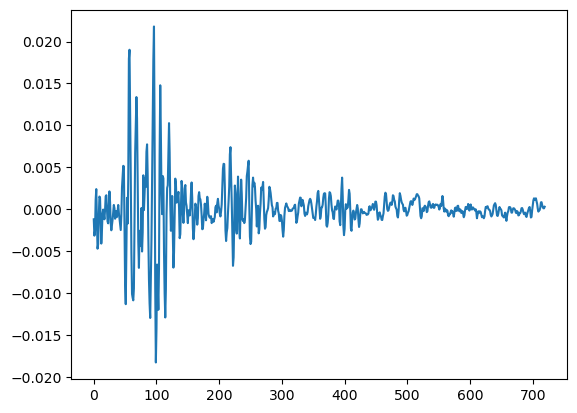

In [77]:
plt.plot(birthaudio[0,:])

In [78]:
birthaudio.shape, birthclicks.shape

((8950, 720), (8950, 16))

In [79]:
# Optionally save the audio
tstamp = get_timestamp_now()[0]
leftout = birthdir.parent / f'birthclicks.{tstamp}.wav'
sf.write(leftout, birthaudio[birthclicks.index].ravel(), resample_rate)

In [80]:
# Optionally save the audio
tstamp = get_timestamp_now()[0]
for s, saudio in (('unscaled', birthaudio), ('pknorm', ceti.normalize_audio(birthaudio.copy(), remdc=False, peak_scale=1.0))):
    outfile = flacdir.parent / f'birthclicks.{tstamp}.{s}.{saudio.shape[-1]}samples.wav'
    wavfile.write(outfile, birthresample_rate, saudio.ravel())
#    sf.write(outfile, clickaudio[:,chanidx,:].ravel(), resample_rate) # This seems to scale audio
    print(outfile)

# Save click dataframe. The `audidx` column matches dataframe rows to
# its sequence in the audio file.
csvout = flacdir.parent / f'birthclicks.{tstamp}.csv'
birthclicks.to_csv(csvout, index=False)
print(csvout)

/global/scratch/users/rsprouse/datasets/ceti/birthclicks.2024-02-26T095013.unscaled.720samples.wav
/global/scratch/users/rsprouse/datasets/ceti/birthclicks.2024-02-26T095013.pknorm.720samples.wav
/global/scratch/users/rsprouse/datasets/ceti/birthclicks.2024-02-26T095013.csv


In [81]:
birthclicks = birthclicks.reset_index(drop=True)
whaledf = pd.DataFrame({
    'text': birthclicks[~birthclicks['SegmentWhale'].duplicated()]['SegmentWhale'].astype(str),
    't1': birthclicks[~birthclicks['SegmentWhale'].duplicated()].index * click_window,
    't2': birthclicks[~birthclicks['SegmentWhale'].duplicated(keep='last')].index * click_window + click_window
})
whaledf

codadf = pd.DataFrame({
    'text': birthclicks[~birthclicks['fauxcoda'].duplicated()]['fauxcoda'].astype(str),
    't1': birthclicks[~birthclicks['fauxcoda'].duplicated()].index * click_window,
    't2': birthclicks[~birthclicks['fauxcoda'].duplicated(keep='last')].index * click_window + click_window
})
codadf

clickdf = pd.DataFrame({
    'text': birthclicks['clicknum'].astype(str),
    't1': birthclicks.index * click_window,
    't2': birthclicks.index * click_window + click_window
})
clickdf

clicktg = df2tg(
    [whaledf, codadf, clickdf],
    tnames=['whale', 'coda', 'clicknum'],
    lbl='text',
    fmt='0.4f',
    fill_gaps=None,
    outfile=specdir.parent / f'birthclicks.{tstamp}.TextGrid'
)
print(outfile)

/global/scratch/users/rsprouse/datasets/ceti/birthclicks.2024-02-26T095013.pknorm.720samples.wav


# Leftovers

Code not currently in use.

In [ ]:
# TODO
# Use parselmouth to get ltas from praat
# Assemble all audio as a single concatenated .wav file
# For metadata csv file, just grab the whole row from classifiedCodasProc and add to click csv
# Append spectral data to metadata .csv file (long format as binHz & binAmp columns)
# Also assemble audio slices as ndarray and save in R-compatible format

# TODO
# pad 25ms
# resample 48k
# play with spectral analysis and formants

def hhmmss2sec(s):
    '''
    Convert a HH:MM:SS string to seconds.
    '''
    hh, mm, ss = s.split(':')
    return int(hh) * 3600 + int(mm) * 60 + int(ss)

def praat_ltas(snd, bwhz, return_freqs):
    ltas = pcall(snd, 'To Ltas...', bwhz)
    nbins = pcall(ltas, 'Get number of bins')
    vals = [pcall(ltas, 'Get value in bin', i) for i in range(1, nbins+1)]
    if return_freqs is True:
        freqs = [
            pcall(ltas, 'Get frequency from bin number...', i) for i in range(1, nbins+1)
        ]
        return (vals, freqs)
    else:
        return vals

def load_flac_info(flacdir):
    '''
    Find all .flac files and load as a dataframe with samplerate and durations.
    
    If cached results are available, use those instead.
    '''
    flacinfofile = flacdir / 'flacinfo.csv'
    if flacinfofile.exists():
        dtypes = {
            'relpath': str,
            'fname': str,
            'barename': str,
            'flacrate': int,
            'flacdur': float,
            'tag': str,
            'fseq': int,
            'foffset': float
        }
        flacdf = pd.read_csv(flacinfofile, dtype=dtypes)
    else:
        flacdf = dir2df(flacdir, fnpat='(?P<tag>[a-z]+\d+[a-z])(?P<fseq>\d+)\.flac$', dirpat=r'20\d\d', addcols=['barename', 'ext'])
        flacdf['fseq'] = flacdf['fseq'].astype(int)
        flacdf['flacrate'] = [sf.info(flacdir / f.relpath / f.fname).samplerate for f in flacdf.itertuples()]
        flacdf['flacdur'] = [sf.info(flacdir / f.relpath / f.fname).duration for f in flacdf.itertuples()]
        flacdf['foffset'] = flacdf.groupby('tag', group_keys=False).apply(
            lambda x: x['flacdur'].shift(fill_value=0).cumsum()
        )
        flacdf.to_csv(flacinfofile, index=False)
    return flacdf

def load_classified_codas(url, dropIPI):
    '''
    Load codas found in google classifiedCodasProc spreadsheet as a dataframe.
    '''
    codas = pd.read_csv(
        url, dtype={'codaNUM2018': str, 'IDN': str, 'nClicks': np.int64}
    )
    if dropIPI is True:   # Drop IPI# columns if requested
        codas = codas.drop(
            [c for c in codas.columns if c.startswith('IPI')],
            axis='columns'
        )
    barenamere = re.compile(r'''
        (?P<barename>             # Corresponds to .flac filename
          (?P<tagmatch>sw\d+[a-z]) # Expected to match 'Tag' column
          (?P<fileseq>\d+)        # Sequence of this file in audio files for Tag
        )
        (?:
          _                     # Separator for optional
          (?P<seg>.+)           # following digits of unknown meaning
        )?
    ''', re.VERBOSE)
    codas = pd.concat(
        [
            codas['REC'].str.extract(barenamere).fillna(''),
            codas
        ],
        axis='columns'
    )
    assert((codas['tagmatch'] == codas['Tag']).all())
    return codas.drop('tagmatch', axis='columns')

def load_cached_spectra(csvfile):
    '''
    Load spectral analysis from cached .npy and .csv files.
    '''
    return {
        'wfreqs': np.load(csvfile.with_suffix('.welchfreqs.npy')),
        'pfreqs': np.load(csvfile.with_suffix('.praatfreqs.npy')),
        'lfreqs': np.load(csvfile.with_suffix('.ltasfreqs.npy')),
        'au': np.load(csvfile.with_suffix('.audio.npy')),
        'welch': np.load(csvfile.with_suffix('.welchspec.npy')),
        'praat': np.load(csvfile.with_suffix('.praatspec.npy')),
        'ltas': np.load(csvfile.with_suffix('.ltasspec.npy')),
        'md': pd.read_csv(
            csvfile,
            dtype={'codaNUM2018': str, 'clicknum': int, 'text': str, 'IDN': str}
        )
    }

def get_single_click_audio(aufile, t1, click_offset, click_window, resample_rate, verbose=True):
    with sf.SoundFile(aufile, 'r') as fh:
        sr_native = fh.samplerate
        nsamp = int(click_window * sr_native)
        fh.seek(int((t1 + click_offset) * sr_native))
        # Load the target number of frames, and transpose to match librosa form
        y = fh.read(frames=nsamp, dtype=np.float32, always_2d=False).T
        if sr_native != resample_rate:
            y = librosa.resample(y, orig_sr=sr_native, target_sr=resample_rate)
        if verbose is True:
            print(f'Read from time {t1 + click_offset} in {aufile}')
    return y

def extract_click_audio(clickdf, codacol, t1col, click_offset, click_window, audiodir, resample_rate, groupby):
    '''
    Extract audio chunks for each click row in a dataframe.
    
    For better performance the input dataframe is sorted by source file and coda id.
    '''
    try:
        assert(clickdf.index.start == 0)
        assert(clickdf.index.step == 1)
    except AssertionError:
        raise RuntimeError('Input dataframe must have a zero-based range index.')
    audio = None
#    audio2 = None
#    dfs = []
    errors = []
#    clickdf = clickdf.copy() \
#                     .sort_values(['barename', codacol]) \
#                     .reset_index(drop=True)
#    idx = 0
    for _, audf in clickdf.groupby(groupby):
        aufile = Path(audiodir) / audf.iloc[0]['relpath'] / f"{audf.iloc[0][groupby]}{audf.iloc[0]['ext']}"
        with sf.SoundFile(aufile, 'r') as fh:
            sr_native = fh.samplerate
            if sr_native < resample_rate:
                sys.stderr.write(
                    f'WARNING: Upsampling {aufile} from {sr_native} to {resample_rate}.\n'
                )
            nsamp = int(click_window * sr_native)
            for __, cdf in audf.groupby(codacol):
                for row in cdf.itertuples():
                    try:
                        fh.seek(int((row.t1 + click_offset) * sr_native))
                        # Load the target number of frames, and transpose to match librosa form
                        y = fh.read(frames=nsamp, dtype=np.float32, always_2d=False).T
                        if sr_native != resample_rate:
                            y = librosa.resample(
                                y, orig_sr=sr_native, target_sr=resample_rate
                            )
                        if audio is None:
                            audio = (
                                np.empty(
                                    (len(clickdf), ) + y.shape,
                                    dtype=np.float32
                                ) * np.nan
                            )
#                            audio2 = (
#                                np.empty(
#                                    (len(clickdf), ) + y.shape,
#                                    dtype=np.float32
#                                ) * np.nan
#                            )
                    except Exception as e:
                        errors.append(row.Index)
                    audio[row.audidx] = y
#                    audio[row.Index] = y
#                    audio2[row.audidx] = y
    audio = np.array(audio)
#    audio2 = np.array(audio2)
    mu = audio.mean(axis=-1, keepdims=True)
#    mu2 = audio2.mean(axis=-1, keepdims=True)
    audio -= mu # Remove DC offset
#    audio2 -= mu2 # Remove DC offset
    audio /= np.abs(audio).max(axis=-1, keepdims=True) * 0.99  # Normalize max magnitude to 0.99
#    audio2 /= np.abs(audio2).max(axis=-1, keepdims=True) * 0.99  # Normalize max magnitude to 0.99
    return (audio, clickdf[clickdf.index.isin(errors)])

# TODO: as-is this is too particular for a specific dataframe
def clicks2tg(mydf):
    '''
    Compile textgrid tiers from dataframe of clicks.
    '''
    clickdf = pd.DataFrame({
        'whale': mydf['Name'],
        'coda': mydf['codaNUM2018'],
        'click': mydf['clicknum'].astype(str),
        't1': mydf.index * click_window,
        't2': (mydf.index + 1) * click_window
    })
    clickdf = clickdf.set_index(['whale', 'coda'])

    whaledf = clickdf[['t1', 't2']] \
              .groupby('whale') \
              .agg([min, max]) \
              .loc[:, [('t1', 'min'), ('t2', 'max')]] \
              .droplevel(1, axis='columns') \
              .reset_index()

    codadf = clickdf[['t1', 't2']] \
              .groupby(['coda']) \
              .agg([min, max]) \
              .loc[:, [('t1', 'min'), ('t2', 'max')]] \
              .droplevel(1, axis='columns') \
              .reset_index()

    clicktg = df2tg(
        [whaledf, codadf, clickdf],
        tnames=['whale', 'coda-bout', 'clicknum'],
        lbl=['whale', 'coda', 'click'],
        fmt='0.4f',
        outfile=specdir.parent / 'allcodas-clicks.focal.20231005.2.fg.TextGrid'
    )

def codas2clicks(codadf):
    '''
    Transform the codas in a dataframe to a list of per-whale
    coda|click dataframes and associated names of the form
    `{whaleid}-(codas|clicks)`.
    '''
    codalists = {}
    for coda in codadf.itertuples():
        codadict = {
            't1': coda.TsTo,
            't2': coda.TsTo + coda.Duration,
        }
        try:
            codalists[f'{coda.IDN}-codas'].append(coda._asdict() | codadict)
        except KeyError:
            codalists[f'{coda.IDN}-codas'] = [coda._asdict() | codadict]
        t1 = coda.TsTo
        for clicknum in np.arange(1, coda.nClicks + 1, dtype=int):
            clickdur = getattr(coda, f'ICI{int(clicknum)}')
            clickdict = {
                't1': t1,
                'clicknum': clicknum,
            }
            try:
                codalists[f'{coda.IDN}-clicks'].append(coda._asdict() | clickdict)
            except KeyError:
                codalists[f'{coda.IDN}-clicks'] = [coda._asdict() | clickdict]
            t1 += clickdur
    dfs = []
    for v in codalists.values():
        vdf = pd.DataFrame(v)
        vdf['nClicks'] = vdf['nClicks'].astype(str)
        if 'clicknum' in vdf.columns:
            vdf['clicknum'] = vdf['clicknum'].astype(str)
        dfs.append(vdf.drop('Index', axis='columns'))
    return (dfs, list(codalists.keys()))

def specs2long(row, welchspecarray, praatspecarray, ltasspecarray, freqs):
    '''
    Arrange spectral measures in long format and combine with click metadata
    keys for later merging.
    '''
    return {
        'codaNUM2018': row.codaNUM2018,
        'clicknum': row.clicknum,
        'binHz': np.hstack((freqs['welch'], freqs['praat'], freqs['ltas'])),
        'binval': np.hstack((
            (10*np.log10(np.abs(welchspecarray[row.Index])/2e-5)),
            (10*np.log10(np.abs(praatspecarray[row.Index,0,:])/2e-5)),
            ltasspecarray[row.Index]
        )),
        'spectype': \
            ['welch'] * len(freqs['welch']) + \
            ['praat'] * len(freqs['praat']) + \
            ['ltas'] * len(freqs['ltas'])
    }

def get_click_audio_old(fh, t1s, rate, offset, window, mono):
    '''
    Get all the audio corresponding to rows of a dataframe. All rows are
    expected to have the same 'relpath' and 'fname' values for the .flac file.
    '''
    audio = []
    t1s = clickdf['ICI'].shift(fill_value=clickdf.iloc[0]['TsTo']).cumsum()
    for t1 in t1s:
        au, _ = librosa.load(
            fh, sr=rate, mono=mono, offset=t1+offset, duration=window
        )
        audio.append(au)
    return audio

In [ ]:
%%timeit -r1 -n1
audio = []
for _, flacdf in allcodas.groupby('barename'):
    flacfile = flacdir / flacdf.iloc[0]['relpath'] / flacdf.iloc[0]['fname']
    with sf.SoundFile(flacfile, 'r') as fh:
        sr_native = fh.samplerate
        if sr_native < resample_rate:
            sys.stderr.write(f'WARNING: Upsampling {flacfile} from {sr_native} to {resample_rate}.\n')
        nsamp = int(click_window * sr_native)
        for __, clickdf in flacdf.groupby('codaNUM2018'):
            t1s = clickdf['ICI'].shift(fill_value=clickdf.iloc[0]['TsTo']).cumsum()
            for t1 in t1s:
                fh.seek(int((t1 + click_offset) * sr_native))
                # Load the target number of frames, and transpose to match librosa form
                y = fh.read(frames=nsamp, dtype=np.float32, always_2d=False).T
                audio.append(
                    librosa.resample(y, orig_sr=sr_native, target_sr=resample_rate)
                )
audio = np.array(audio)
mu = audio.mean(axis=-1, keepdims=True)
audio -= mu # Remove DC offset
audio /= np.abs(audio).max(axis=-1, keepdims=True) * 0.99  # Normalize max magnitude to 0.99

## Process codas

Find all coda entries that have a matching `.flac` file and do spectral analysis on the clicks.

In [ ]:
results = {'success': [], 'failure': []}
mycodas = allcodas[(allcodas['relpath'] != '') & (allcodas['REC'] != '')]
for name, codadf in mycodas.groupby('barename'):
    # Create per-whale coda and click dataframes for a .flac file.
    dfs, tiers = codas2clicks(codadf)

    # Write the results to a textgrid.
    relpath = codadf.iloc[0]['relpath']
    tgfile = tgdir / relpath / f'{name}.tg'
    tgfile.parent.mkdir(parents=True, exist_ok=True)
    tg = df2tg(
        dfs,
        tnames=tiers,
        t2=['t2' if 't2' in df.columns else None for df in dfs],
        lbl=['clicknum' if 'clicknum' in df.columns else 'nClicks' for df in dfs],
        fmt='0.4f',
        fill_gaps=None,  # Some codas overlap, which makes textgrid unreadable by Praat if this is True
        outfile=tgfile
    )

    # Get spectra of individual clicks in a .flac file.
    for tname, df in zip(tiers, dfs):
        # Process -clicks dfs and skip -codas dfs.
        if not tname.endswith('-clicks'):
            continue
        wspectra = []
        ltasspectra = []
        praatspectra = []
        audio = []
        freqs = {}
        skiperror = False
        for row in df.itertuples():
            flacfile = flacdir / relpath / f'{name}.flac'
            try:
#                print(click)
                au, _ = librosa.load(
                    flacfile,
                    sr=resample_rate,
                    offset=row.t1+click_offset,
                    duration=click_window
                )
                au = au - au.mean()  # Remove DC offset
                au = au / np.abs(au).max() * 0.99  # Normalize max magnitude to 0.99
                welchfreqs, Pxx = welch(au, fs=resample_rate, nperseg=1024)
                snd = Sound(values=au, sampling_frequency=resample_rate)
                praatspec = snd.to_spectrum(fast=praat_spec_fast)
                if freqs == {}:
                    ltas, ltasfreqs = praat_ltas(snd, ltas_bw, True)
                    freqs = {
                        'welch': welchfreqs,
                        'ltas': ltasfreqs,
                        'praat': praatspec.xs()
                    }
                else:
                    ltas = praat_ltas(snd, ltas_bw, False)
                wspectra.append(Pxx)
                ltasspectra.append(ltas)
                praatspectra.append(praatspec)
                audio.append(au)
                results['success'].append(f'{row.codaNUM2018}-{row.clicknum}')
            except Exception as e:
                results['failure'].append(f'{row.codaNUM2018}-{row.clicknum}')
                if skiperror is False:
                    sys.stderr.write(f'Could not process "{flacfile}" at time {row.t1}: {e}\n\n')
                    skiperror = True
        # Save results
        csvfile = specdir / relpath / f"{name}.{df.iloc[0]['IDN']}.csv"
        csvfile.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(csvfile, index=False)
        np.save(csvfile.with_suffix('.welchspec.npy'), np.array(wspectra))
        np.save(csvfile.with_suffix('.praatspec.npy'), np.array(praatspectra))
        np.save(csvfile.with_suffix('.ltasspec.npy'), np.array(ltasspectra))
        np.save(csvfile.with_suffix('.audio.npy'), np.array(audio))
        print(f'Finished {flacfile}')
        if freqs != {}:
            np.save(csvfile.with_suffix('.welchfreqs.npy'), freqs['welch'])
            np.save(csvfile.with_suffix('.praatfreqs.npy'), freqs['praat'])
            np.save(csvfile.with_suffix('.ltasfreqs.npy'), freqs['ltas'])
#            break
#        break
#    break

In [ ]:
stdfs = []
for status in ('success', 'failure'):
    stdf = pd.DataFrame({
        'status': status,
        'codanum': [r.split('-')[0] for r in results[status]]
    })
    stdfs.append(stdf[~stdf.duplicated()].reset_index(drop=True))
statusdf = pd.concat(stdfs, axis='rows')

In [ ]:
resultsdf = statusdf.merge(allcodas, how='outer', left_on='codanum', right_on='codaNUM2018')
Is = [c for c in resultsdf.columns if c.startswith('ICI') or c.startswith('IPI')]
resultsdf = resultsdf.drop(Is, axis='columns')
#resultsdf['TagOnSec'] = resultsdf['TagOnTime'].str.split(':', expand=True).fillna('0').astype(int).apply(lambda x: x[0] * 3600 + x[1] * 60 + x[2], axis='columns')
resultsdf[['status', 'barename', 'TagOnTime', 'TsTo', 'SampleRate', 'flacrate']]

## Load results of last file/whale analysis

In [ ]:
spectra = load_cached_spectra(csvfile)

In [ ]:
spectra['wfreqs']

In [ ]:
frame = 1
fig, axs = plt.subplots(6, 1, figsize=[10, 40])
axs[0].plot(myaudio[frame])
axs[0].set_title = 'audio'
axs[1].plot(mywelchfreqs, mywelchspecs[frame,:])
axs[1].set_title = 'welch spectrum'
axs[2].plot(mywelchfreqs, 10*np.log10(mywelchspecs[frame,:]/2e-5))
axs[2].set_title = 'log-scaled welch spectrum'
axs[2].set_ylim(-100, 0)
axs[3].plot(mypraatfreqs, np.abs(mypraatspecs[frame,0,:]))
axs[3].set_title = 'praat spectrum'
axs[4].plot(mypraatfreqs, 10*np.log10(np.abs(mypraatspecs[frame,0,:])/2e-5))
axs[4].set_title = 'log-scaled praat spectrum'
#axs[4].set_ylim(-100, 0)
axs[5].plot(myltasfreqs, np.abs(myltasspecs[frame,:]))
axs[5].set_title = 'praat ltas spectrum'
fig.tight_layout()
print(mydf.iloc[frame])
audio = Audio(data=myaudio[frame], rate=resample_rate)
display(audio)

## Assemble all spec and csv files

These contain corresponding rows of spectral data and metadata.

In [ ]:
welchspecdf = dir2df(specdir, fnpat=r'(?P<flacfile>[^.]+)\.(?P<whaleid>[^.]+)\.welchspec.npy')
praatspecdf = dir2df(specdir, fnpat=r'(?P<flacfile>[^.]+)\.(?P<whaleid>[^.]+)\.praatspec.npy')
ltasspecdf = dir2df(specdir, fnpat=r'(?P<flacfile>[^.]+)\.(?P<whaleid>[^.]+)\.ltasspec.npy')
csvdf = dir2df(specdir, fnpat=r'(?P<flacfile>[^.]+)\.(?P<whaleid>[^.]+)\.csv')
welchspeccsvdf = welchspecdf.merge(csvdf, how='inner', on=('relpath', 'flacfile', 'whaleid'), suffixes=('_spec', '_csv'))
welchspeccsvdf

In [ ]:
# TODO:
# x Normalize audio peaks to .99
# x Order clicks by whale before saving audio/creating spectra
# Compare AWS audio files to GDrive files to see whether they are not truncated
# x Textgrid for all audio file that shows 1) tier 1 with whalename_bout 2) tier 2 coda 3) tier 3 clicknum
# Save metadata/spectral results in wide and long formats, separated by analysis type
# x Remove log scaling from values
# Save as rda file?
welchspecs = []
praatspecs = []
ltasspecs = []
csvs = []
auds = []
freqs = {}
allspecs = []
for row in welchspeccsvdf.itertuples():
    csvfile = specdir / row.relpath / row.fname_csv
    try:
        spectra = load_cached_spectra(csvfile)
        md, au = spectra['md'], spectra['au']
        assert(len(md) == len(au))
        ws, ps, ls = spectra['welch'], spectra['praat'], spectra['ltas']
        welchspecs.append(ws)
        praatspecs.append(ps)
        ltasspecs.append(ls)
        csvs.append(md)
        auds.append(au)
        freqs = {
            'welch': spectra['wfreqs'],
            'praat': spectra['pfreqs'],
            'ltas': spectra['lfreqs']
        }
        allspecs.append(pd.DataFrame({
            'binHz': np.hstack((freqs['welch'], freqs['praat'], freqs['ltas'])),
            'binval': np.hstack([
                ws[idx], #                (10*np.log10(np.abs(ws[idx])/2e-5)),
                ps[idx,0,:], #                (10*np.log10(np.abs(ps[idx,0,:])/2e-5)),
                ls[idx]
            ]),
            'spectype': \
                ['welch'] * len(freqs['welch']) + \
                ['praat'] * len(freqs['praat']) + \
                ['ltas'] * len(freqs['ltas'])
        }))
    except AssertionError as e:
        print(f'md {md.shape} and au {au.shape} for {csvfile} do not match.\n')
    except Exception as e:
#        print(f'Could not load md and spectra for {csvfile}:\n{e}')
        continue
# Reset index to ensure zero-based indexing to coordinate with np arrays.
csvdf = pd.concat(csvs, axis='rows').reset_index(drop=True)
### Sort by whale, coda, click
csvdf = csvdf.sort_values(['Name', 'codaNUM2018', 'clicknum'])

# Use csvdf.Index to assure same sort as csvdf
welchspecarray = np.vstack(welchspecs)[csvdf.index]
praatspecarray = np.vstack(praatspecs)[csvdf.index]
ltasspecarray = np.vstack(ltasspecs)[csvdf.index]
audioarray = np.vstack(auds)[csvdf.index]

# Now reset index to zero-based to match np arrays
csvdf = csvdf.reset_index(drop=True)

In [ ]:
# Filter for focal whales only
# Optional step (execute only once!)
focalidx = csvdf[csvdf['Focal'] == 1].index
csvdf = csvdf.loc[focalidx,:]
welchspecarray = welchspecarray[focalidx]
praatspecarray = praatspecarray[focalidx]
ltasspecarray = ltasspecarray[focalidx]
audioarray = audioarray[focalidx]
csvdf = csvdf.reset_index(drop=True)

In [ ]:
# Optionally save the audio
wavout = specdir.parent / 'allcodas.focal.20231004.wav'
sf.write(wavout, audioarray.ravel(), resample_rate)

In [ ]:
csvdf.shape, audioarray.shape

In [ ]:
welchspecarray.shape, praatspecarray.shape, ltasspecarray.shape

In [ ]:
freqs['welch'].shape, freqs['praat'].shape, freqs['ltas'].shape

In [ ]:
longspecs = [
    specs2long(
        r, welchspecarray, praatspecarray, ltasspecarray, freqs
    ) for r in csvdf.itertuples()
]

In [ ]:
longspecsdf = pd.concat([pd.DataFrame(d) for d in longspecs])
longspecsdf.shape

In [ ]:
finaldf = longspecsdf.merge(csvdf, how='left', on=('codaNUM2018', 'clicknum'))
finaldf.shape

### Make textgrid tiers

In [ ]:
finwelchdf = finaldf[
    (finaldf['spectype'] == 'welch') & \
    (finaldf['binHz'] == 0.0)
].reset_index(drop=True)

In [ ]:
finwelchdf.shape[0] * click_window

In [ ]:
finaldf.shape

In [ ]:
# Whale tier
whales = []
codas = []
clicks = []
for wgb in finwelchdf.groupby('Name'):
    wht1 = (wgb[1].index[0] * click_window)
    whales.append({
        'text': wgb[0],
        't1': wht1,
        't2': wgb[1].shape[0] * click_window + wht1
    })
    for coda in wgb[1].reset_index().groupby('codaNUM2018'):
        cdt1 = coda[1].index[0] * click_window + wht1
        codas.append({
            'text': f"{coda[0]}-{int(coda[1].iloc[0]['Bout'])}",
            't1': cdt1,
            't2': coda[1].shape[0] * click_window + cdt1
        })
        for row in coda[1].itertuples():
            clt1 = row.clicknum * click_window + cdt1
            clicks.append({
                'text': str(row.clicknum),
                't1': clt1,
                't2': click_window + clt1
            })
whaledf = pd.DataFrame(whales)
whaledf
codadf = pd.DataFrame(codas)
codadf
clickdf = pd.DataFrame(clicks)
clickdf

In [ ]:
clicktg = df2tg(
    [whaledf, codadf, clickdf],
    tnames=['whale', 'coda-bout', 'clicknum'],
    lbl='text',
    fmt='0.4f',
    fill_gaps=None,
    outfile=specdir.parent / 'allcodas-clicks.focal.20231004.TextGrid'
)

In [ ]:
for sptyp in ('welch', 'praat', 'ltas'):
    finalcsv = specdir / r'finalspecs.{styp}.csv'
    finaldf[finaldf['spectype'] == styp].to_csv(finalcsv, index=False)

# Slower but less memory required
finalcsv = specdir / 'finalspecs.csv'
with open(finalcsv, 'a') as out:
    for i, r in enumerate(csvdf.itertuples()):
        finaldf = pd.DataFrame(
            specs2long(
                r, welchspecarray, praatspecarray, ltasspecarray, freqs
            )
        ) \
        .merge(csvdf, how='left', on=('codaNUM2018', 'clicknum')) \
        .to_csv(out, mode='a', index=False, header=(i==0))


## Read `.csv` of spectral measures

In [ ]:
speccsv = specdir / 'finalspecs.fast.csv'
sdf = pd.read_csv(speccsv, nrows=100000)
sdf.shape

In [ ]:
# Number of codas
sdf['codaNUM2018'].unique().shape

In [ ]:
# Number of coda clicks
sgby = sdf.groupby(['codaNUM2018', 'clicknum'])
sgby.ngroups

In [ ]:
sdf.codaNUM2018.unique()

### Plot click spectrums

In [ ]:
codanum = 8365
clicknum = 3
spectypes = ['welch', 'praat', 'ltas']
cdf = sdf[(sdf['codaNUM2018'] == codanum) & (sdf['clicknum'] == clicknum)]
fig, axs = plt.subplots(len(spectypes))
for i, styp in enumerate(spectypes):
    pltdf = cdf[cdf['spectype'] == styp]
    axs[i].plot(pltdf['binHz'][1:], pltdf['binval'][1:])
#axs[2].set_ylim(-25, 35)

In [ ]:
cdf.pivot_table(index=['spectype'], columns='binHz', values='binval')

In [ ]:
fig, axs = plt.subplots(6, 1, figsize=[10, 40])
#axs[0].plot(myaudio[frame])
#axs[0].set_title = 'audio'
axs[1].plot(mywelchfreqs, mywelchspecs[frame,:])
axs[1].set_title = 'welch spectrum'
axs[2].plot(mywelchfreqs, 10*np.log10(mywelchspecs[frame,:]/2e-5))
axs[2].set_title = 'log-scaled welch spectrum'
axs[2].set_ylim(-100, 0)
axs[3].plot(mypraatfreqs, np.abs(mypraatspecs[frame,0,:]))
axs[3].set_title = 'praat spectrum'
axs[4].plot(mypraatfreqs, 10*np.log10(np.abs(mypraatspecs[frame,0,:])/2e-5))
axs[4].set_title = 'log-scaled praat spectrum'
#axs[4].set_ylim(-100, 0)
axs[5].plot(myltasfreqs, np.abs(myltasspecs[frame,:]))
axs[5].set_title = 'praat ltas spectrum'
fig.tight_layout()
print(mydf.iloc[frame])
audio = Audio(data=myaudio[frame], rate=resample_rate)
display(audio)

## Leftovers

In [ ]:
welchspecs = []
praatspecs = []
ltasspecs = []
csvs = []
auds = []
freqs = {}
for row in welchspeccsvdf.itertuples():
    wspec = np.load(specdir / row.relpath / row.fname_spec)
    pspec = np.load(specdir / row.relpath / row.fname_spec.replace('welch', 'praat'))
    lspec = np.load(specdir / row.relpath / row.fname_spec.replace('welch', 'ltas'))
    df = pd.read_csv(
        specdir / row.relpath / row.fname_csv,
        dtype={'codaNUM2018': str, 'clicknum': int, 'text': str, 'IDN': str}
    )
    aud = np.load(specdir / row.relpath / row.fname_spec.replace('welchspec', 'audio'))
    try:
        assert(len(spec) == len(df))
        welchspecs.append(wspec)
        praatspecs.append(pspec)
        ltasspecs.append(lspec)
        csvs.append(df)
        auds.append(aud)
        if freqs == {}:
            freqs['welch'] = np.load(specdir / row.relpath / row.fname_spec.replace('welchspec', 'welchfreqs'))
            freqs['ltas'] = np.load(specdir / row.relpath / row.fname_spec.replace('ltasspec', 'ltasfreqs'))
            freqs['praatspec'] = np.load(specdir / row.relpath / row.fname_spec.replace('praatspec', 'praatfreqs'))
    except AssertionError:
        pass
csvdf = pd.concat(csvs, axis='rows')
welchspecarray = np.vstack(welchspecs)
praatspecarray = np.vstack(praatspecs)
ltasspecarray = np.vstack(ltasspecs)
audioarray = np.vstack(auds)

In [ ]:
assert(len(csvdf) == len(welchspecarray) == len(audioarray))

In [ ]:
freqs['praatspec']

In [ ]:
praatspecarray[idx][0].shape

In [ ]:
idx = 1
specmaxidx = welchspecarray[idx,:].argmax()
maxfreq = freqs['welch'][specmaxidx]
print(f"Spectrum of coda {csvdf.iloc[idx]['codaNUM2018']} at click {csvdf.iloc[idx]['clicknum']} for whale {csvdf.iloc[idx]['IDN']}; Max frequency: {maxfreq}")
fig, axs = plt.subplots(4)      
axs[0].plot(audioarray[idx])
axs[0].set_title = 'audio'
axs[1].plot(freqs['welch'], 10*np.log10(welchspecarray[idx]/2e-5))
axs[2].plot(freqs['welch'], welchspecarray[idx])
axs[3].plot(freqs['praatspec'], 10*np.log10(np.abs(praatspecarray[idx][0])/2e-5))
fig.tight_layout()
audio = Audio(data=audioarray[idx], rate=resample_rate)
display(audio)

In [ ]:
list(csvdf.iloc[idx].keys())

In [ ]:
fig = plt.figure(figsize=(10, 2))
plt.imshow(10*np.log10(specarray.T/2e-5));

## Textgrids

In [ ]:
tgdf = dir2df(tgdir, addcols='barename')

In [ ]:
tgdf